<a href="https://colab.research.google.com/github/gpvillegas/hugs2024/blob/main/qcdcarpentry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/QCDHUB/qcdcarpentry.git

Cloning into 'qcdcarpentry'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 85 (delta 13), reused 68 (delta 5), pack-reused 0
Receiving objects: 100% (85/85), 7.89 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
cd qcdcarpentry/

/content/qcdcarpentry


In [ ]:
ls

database/  logos/  MC.ipynb  QCD-carpentry-workbook.ipynb  readme.md


In [ ]:
import sys,os,time
import numpy as np
import pandas as pd
import copy
import threading

#--matplotlib
import matplotlib
#matplotlib.rc('text',usetex=True)
import pylab  as py
#from matplotlib.lines import Line2D

#--scipy
from scipy.integrate import fixed_quad
from scipy.integrate import quad
from scipy.special import gamma

#--mpmath
from mpmath import fp
import math

#--from scipy
from scipy.optimize  import minimize,leastsq
from scipy.optimize  import least_squares

#--jupyter widgets
from IPython.display import display,clear_output
import ipywidgets as widgets

## AUX class

The AUX class below is used to store masses and fundamental constants of nature.  These will be used frequently in the exercises below.

In [ ]:
class AUX:

    def __init__(self):

        #--set_constants

        self.CA=3.0
        self.CF=4.0/3.0
        self.TR=0.5
        self.TF=0.5
        self.euler=fp.euler

        #--set_masses

        self.me   = 0.000511
        self.mm   = 0.105658
        self.mt   = 1.77684
        self.mu   = 0.055
        self.md   = 0.055
        self.ms   = 0.2
        self.mc   = 1.28
        self.mb   = 4.18

        self.mZ   = 91.1876
        self.mW   = 80.398
        self.M    = 0.93891897
        self.Mpi  = 0.13803
        self.Mk   = 0.493677
        self.Mdelta = 1.232

        self.me2   = self.me**2
        self.mm2   = self.mm**2
        self.mt2   = self.mt**2
        self.mu2   = self.mu**2
        self.md2   = self.md**2
        self.ms2   = self.ms**2
        self.mc2   = self.mc**2
        self.mb2   = self.mb**2
        self.mZ2   = self.mZ**2
        self.mW2   = self.mW**2
        self.M2    = self.M**2
        self.Mpi2  = self.Mpi**2
        self.Mdelta2=self.Mdelta**2

        #--set_couplings

        self.c2w   = self.mW2/self.mZ2
        self.s2w   = 1.0-self.c2w
        self.s2wMZ = 0.23116
        self.c2wMZ = 1.0 - self.s2wMZ
        self.alfa  = 1/137.036
        self.alphaSMZ = 0.118
        self.GF = 1.1663787e-5   # 1/GeV^2

### Attention:
- We will use the `conf` dictionary to store class instances
- Classes defined below will often use pre-loaded class instances within `conf`

Here we test storing the AUX class in conf and then printing the mass of the proton.

In [ ]:
conf={}
conf['aux']=AUX()
print(conf['aux'].M)

0.93891897


## Electromagnetic Coupling

The EWEAK class handles the running of the electromagnetic coupling.  It is approximately equal to 1/137, but in reality it changes (or "runs") with the energy scale, hence the term "running coupling."

In [ ]:
class EWEAK:

    def __init__(self):
        self.aux=conf['aux']
        self.ml2 = np.array([self.aux.me2,self.aux.mm2,self.aux.mt2])
        self.mq2 = np.array([self.aux.mu2,self.aux.md2,self.aux.ms2,self.aux.mc2,self.aux.mb2])
        self.eq  = np.array([2./3, -1./3, -1./3, 2./3, -1./3])
        self.gvl = (-1.0)*(-1.0 + 4*self.aux.s2w)/2
        self.i3q = np.array([0.5, -0.5, -0.5, 0.5, -0.5])
        self.gvq = self.i3q - 2*self.eq*self.aux.s2w
        self.alfa = self.aux.alfa
        self.logc2w = np.log(self.aux.c2w)
        self.alpha = {}
        self.kappa = {}

    def get_PIlepton(self,Q2,flag):
        #--lepton loop contribution
        if Q2 >= 2.e-8:
            u = 4*self.ml2/Q2
            su = np.sqrt(1.0+u)
            tmp = ( (1.0-u/2)*su*np.log((su+1.0)/(su-1.0)) + u - 5.0/3 )/3
        else:
            tmp = Q2/15./self.ml2
        if   flag=='gg': return np.sum(tmp)
        elif flag=='gZ': return np.sum((-np.log(self.aux.mZ2/self.ml2)/3 + tmp)*self.gvl)

    def get_PIquark(self,Q2,flag):
        #--quark loop contribution
        if Q2 >= 2.e-5:
            u = 4*self.mq2/Q2
            su = np.sqrt(1.0+u)
            tmp = ( (1.0-u/2)*su*np.log((su+1.0)/(su-1.0)) + u - 5.0/3 )/3
        else:
            tmp = Q2/15./self.mq2
        if   flag=='gg': return np.sum(3*tmp*self.eq**2)
        elif flag=='gZ': return np.sum(3*(-np.log(self.aux.mZ2/self.mq2)/3 + tmp)*self.gvq*self.eq)

    def get_kapb(self,Q2):
        #--boson loop contribution to kappa
        if Q2 >= 1.0:
            z = self.aux.mW2/Q2
            p = np.sqrt(1.0 + 4*z)
            logp = np.log((p+1.0)/(p-1.0))
            PIb = 1./18 \
              + ( -1.0 - 42*self.aux.c2wMZ ) * self.logc2w/12 \
              - ( self.aux.c2wMZ*(7.0 - 4*z) + (1.0 + 4*z)/6 ) * ( p*logp/2 - 1.0 ) \
              - z * ( 0.75 - z + p*(z-1.5)*logp + (2.0-z)*z*logp**2 )
            return -(self.alfa/np.pi)/(2*self.aux.s2wMZ) * PIb
        else:
            return - self.alfa*(-43.0 - 444*self.aux.c2wMZ)*Q2 / (1440*self.aux.mW2*np.pi*self.aux.s2wMZ) \
             + self.alfa*(-16.0 - 12*self.aux.c2wMZ + 3*self.logc2w + 126*self.aux.c2wMZ*self.logc2w) \
               / (72*np.pi*self.aux.s2wMZ)

    def get_alpha(self,Q2):
        #--running of alpha_em
        if Q2 not in self.alpha:
            dalpl = (self.alfa/np.pi) * self.get_PIlepton(Q2,'gg')
            dalpq = (self.alfa/np.pi) * self.get_PIquark(Q2,'gg')
            self.alpha[Q2] = self.alfa/(1.0-dalpl-dalpq)
        return self.alpha[Q2]

    def get_sin2w(self,Q2):
        if Q2 not in self.kappa:
            kapl = -(self.alfa/np.pi)/(2*self.aux.s2wMZ) * self.get_PIlepton(Q2,'gZ')
            kapq = -(self.alfa/np.pi)/(2*self.aux.s2wMZ) * self.get_PIquark(Q2,'gZ')
            kappa = 1.0 + kapl + kapq + self.get_kapb(Q2)
            self.kappa[Q2] = kappa
        return self.kappa[Q2]*self.aux.s2wMZ

To test the EWEAK class, it is first necessary to store the AUX class in conf.  Then we can initiate the EWEAK class and use the get_alpha function to calculate the weak coupling.

In [ ]:
conf={}
conf['aux']=AUX()
eweak=EWEAK()
mu2=1000.0
print(eweak.get_alpha(mu2))

0.007669301913676254


Note that the coupling is close to, but not equal to, 1/137 = 0.007299, due to the running of the coupling.

Before getting into the exercises, let's go over the basics of making plots in Python.  Let's plot y = x^2 with x ranging from 0 to 5.  We do this by first creating an array of 100 x values linearly spaced between 0 and 5.  Then we define y = x^2.

In [ ]:
x = np.linspace(0,5,100)
y = x**2

We then create a figure, which can be split into multiples subfigures using py.subplot.

To plot a line, we use ax.plot(x,y).

There are many ways to change the presentation of a figure.  Below are some lines that allow you to make the x/y scale logarithmic, add vertical or horizontal lines to the plot, and set the x and y labels.

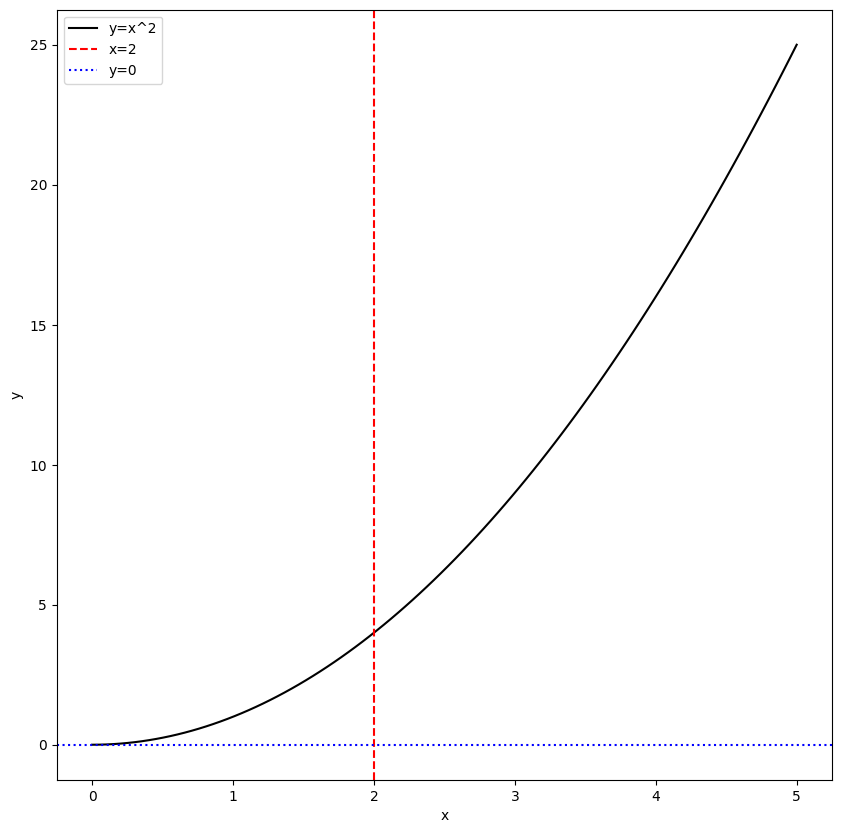

In [ ]:
fig = py.figure(figsize=(10,10))
ax = py.subplot(1,1,1)

ax.plot(x,y,color='black', label='y=x^2')

#ax.semilogx()
#ax.semilogy()

ax.axvline(2,color='red', ls='--', label='x=2')
ax.axhline(0,color='blue',ls=':',  label='y=0')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.legend()


## Exercise 1

- Plot $\alpha_{\rm EM}$ as a function of $\mu^2 \in (m_e^2, 10^4)$
- Include vertical lines indicating the mass thresholds $m_{e}^2,~m_{\mu}^2,~m_{\tau}^2$
- Tip: The plot will look much better if you make the $x$ and $y$ scales logarithmic

## Strong Coupling $\alpha_S$

The ALPHAS class handles the running of the strong coupling.

- The QCD running coupling is given by the following RGE

  $\frac{da_S (\mu^2)}{d\ln \mu^2} =\beta(\mu^2)= -\sum_{k=0}^{\infty} \beta_k a_s^{k+2}(\mu^2)$

  with
  
  $a_s(\mu^2) = \frac{\alpha_S(\mu^2)}{4\pi}$
  
- To solve the RGE we need to have a boundary condition. We shall use the known value of $\alpha_S(m_Z)=0.118$
- **Mass thresholds** are defined at the points $\mu=m_c,m_b$
- The beta function is discontinuous at at the mass thresholds due to $N_f=3,4,5$
- To solve the RGE in the range $1\leq\mu^2\leq\infty$ we need to build boundary conditions for each region with the same $N_f$  (see the `if` statements of the function ``get_a(mu2)``)
- The boundary conditions are computed at the mass thresholds

In [ ]:
class ALPHAS:

    def __init__(self,order=1):
        """
        order=0: 1-loop
        order=1: 2-loops
        """
        if 'order' in conf: order=conf['order']
        self.order=order
        self.mu20=1
        self.setup()

    def setup(self):
        aux = conf['aux']

        #--setup the beta function
        self.beta=np.zeros((7,3))
        for Nf in range(3,7):
            self.beta[Nf,0]=11.0-2.0/3.0*Nf
            self.beta[Nf,1]=102.-38.0/3.0*Nf
            self.beta[Nf,2]=2857.0/2.0-5033.0/18.0*Nf+325.0/54.0*Nf**2

        # uses alphaS(mZ)--> backwards evolution
        self.aZ  = conf['aux'].alphaSMZ/(4*np.pi)
        self.ab=self.evolve_a(self.aZ,aux.mZ2,aux.mb2,5)
        self.ac=self.evolve_a(self.ab,aux.mb2,aux.mc2,4)
        self.a0=self.evolve_a(self.ac,aux.mc2,self.mu20,3)

        # we will store all Q2 values of alphaS
        self.storage={}


    def get_Nf(self,mu2):
        aux = conf['aux']
        Nf=3
        if mu2>=(aux.mc2): Nf+=1
        if mu2>=(aux.mb2): Nf+=1
        return Nf

    def beta_func(self,a,Nf):
        betaf = -self.beta[Nf,0]
        if self.order>=1: betaf+=-a*self.beta[Nf,1]
        if self.order>=2: betaf+=-a*self.beta[Nf,2]
        return betaf*a**2

    def evolve_a(self,a0,mu20,mu2,Nf):
        # Runge-Kutta implemented in pegasus
        LR = np.log(mu2/mu20)/20.0
        a=a0
        for k in range(20):
            XK0 = LR * self.beta_func(a,Nf)
            XK1 = LR * self.beta_func(a + 0.5 * XK0,Nf)
            XK2 = LR * self.beta_func(a + 0.5 * XK1,Nf)
            XK3 = LR * self.beta_func(a + XK2,Nf)
            a+= (XK0 + 2.* XK1 + 2.* XK2 + XK3) * 0.166666666666666
        return a

    def get_a(self,mu2):
        aux = conf['aux']

        if mu2 not in self.storage:

            if aux.mb2<=mu2:
                mu20,a0,Nf=aux.mb2,self.ab,5
            elif aux.mc2<=mu2 and mu2<aux.mb2:
                mu20,a0,Nf=aux.mc2,self.ac,4
            elif mu2<aux.mc2:
                mu20,a0,Nf=self.mu20,self.a0,3
            self.storage[mu2]=self.evolve_a(a0,mu20,mu2,Nf)

        return self.storage[mu2]

    def get_alphaS(self,mu2):
        return self.get_a(mu2)*4*np.pi

As a starting point, we can initiate the ALPHAS class at two-loops (order=1) and print out $\alpha_S$ at any value of $\mu^2$.

In [ ]:
conf={}
conf['aux']=AUX()
aS=ALPHAS(order=1)
mu2=conf['aux'].mZ2
print(aS.get_alphaS(mu2))

0.11799999990923955


## Exercise 2

- Plot $\alpha_{\rm S}$ as a function of  $\mu^2 \in (1, 10^4)$
- Plot the results at both 1-loop (order=0) and 2-loops (order=1)  
- Include vertical lines indicating the mass thresholds $m_{c}^2,~m_{b}^2$ and $m_{Z}^2$
- Tip: The plot will look much better if you make the x scale logarithmic

## Mellin transforms

The Mellin class is used to perform the inverse Mellin transform.  The integration is done using Guassian quadrature with fixed points along the complex contour.

In [ ]:
class MELLIN:

    def __init__(self,npts=4,c=None):

        #--gen z and w values along coutour
        x,w=np.polynomial.legendre.leggauss(npts)
        znodes=[0,0.1,0.3,0.6,1.0,1.6,2.4,3.5,5,7,10,14,19,25,32,40,50,63]

        Z,W,JAC=[],[],[]
        for i in range(len(znodes)-1):
            a,b=znodes[i],znodes[i+1]
            Z.extend(0.5*(b-a)*x+0.5*(a+b))
            W.extend(w)
            JAC.extend([0.5*(b-a) for j in range(x.size)])
        Z=np.array(Z)
        #--globalize
        self.W=np.array(W)
        self.Z=Z
        self.JAC=np.array(JAC)
        #--gen mellin contour
        if c==None: c=1.9
        phi=3.0/4.0*np.pi
        self.N=c+Z*np.exp(complex(0,phi))
        self.phase= np.exp(complex(0,phi))

    def invert(self,x,F):
        return np.sum(np.imag(self.phase * x**(-self.N) * F)/np.pi * self.W * self.JAC)

In the example below we initiate the Mellin class and then define a function $f(x) = x$.  The Mellin transform of this function is $F(N) = 1/(N+1)$.  We can then test that inverting $F(N)$ gives the same result as evaluating $f(x)$.

In [ ]:
mell=MELLIN()

N = mell.N

f=lambda x: x
F = 1/(N+1)

x=0.1
print(f(x))
print(mell.invert(x,F))

0.1
0.09999995742442114


- Notice $F$ has a pole at $N=-1$. We use $c=1.9$ which is to the right of the pole.
- If we chose a $c<-1$ it won't work

In [ ]:
mell=MELLIN(c=-1.1)

N = mell.N

f=lambda x: x
F=1/(N+1)

x=0.1
print(f(x))
print(mell.invert(x,F))

0.1
-3.266151132972489e-09


## Exercise 3.A

- Let's try $f(x)=x^a(1-x)^b$ with $a=-0.5$ and $b=3$.
- Plot $xf(x)$ vs. $x$ and the inverse mellin transform for $10^{-3}<x<1$   (use log scale for the $x$ axis)
- **Hint**: the mellin transform of $f$ is  $F(N)=\Gamma(N+a)\Gamma(b+1)/\Gamma(N+a+b+1)$
- **Hint**: Gamma function is available via `gamma(...)`
- **Attention**: the pole of $F$ is at $N=-a$. Choose $c>-a$

## Exercise 3.B

Consider the convolution

$\sigma(z)=\int_z^1 \frac{dx}{x}f(x)g\left(\frac{z}{x}\right)$

The mellin transform is  

$\Sigma(N) = F(N)G(N)$

with

$F(N)=\int_0^1 x^{N-1} f(x)$

$G(N)=\int_0^1 x^{N-1} g(x)$

Using

$f(x)=x^a(1-x)^b$ with $a=-0.5$ and $b=3$.

$g(x)=x^c(1-x)^d$ with $c=1.0$ and $d=3$

- Plot: $z\sigma(z)$ vs. $z$ (hint:)
- Plot: $zM^{-1}(\Sigma)$ vs. $z$
- use $10^{-4}<z<1$
- **Hint**: To perform the integration over $x$, use the following: `sigma = np.array([fixed_quad(lambda x: 1/x*f(x)*g(z/x),z,1,n=200)[0] for z in Z])`

## Splitting kernels

The KERNELS class defines all of the splitting functions that are used in the DGLAP evolution equation.

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
warnings.filterwarnings("ignore", message="invalid value encountered in add")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

class KERNELS:

    def __init__(self):

        self.D={}
        self.D['N']      = conf['mellin'].N
        self.D['nflav']  = 6+1
        self.D['norder'] = 2+1
        self.D['Nsize']  = conf['mellin'].N.size
        self.set_abbreviations()
        self.LO_unpolarized_splitting_functions()
        self.NLO_unpolarized_splitting_functions()
        self.load_unpolarized_spl()

    def set_abbreviations(self):

        D=self.D

        D['CA']=3
        D['CF']=4/3
        D['TR']=0.5

        zeta2=fp.zeta(2)
        zeta3=fp.zeta(3)

        N   = D['N']
        N1  = N + 1
        N2  = N + 2
        N3  = N + 3
        N4  = N + 4
        N5  = N + 5
        N6  = N + 6
        N7  = N + 7
        N8  = N + 8

        NM  = N - 1
        NM2 = N - 2
        NMS = NM**2
        NMT = NM**3

        NS  = N**2
        NT  = N**3
        NFO = N**4
        NFI = N**5
        NSI = N**6
        NSE = N**7
        NE  = N**8
        NN  = N**9

        N1S = N1**2
        N1T = N1**3

        N2S = N2**2
        N2T = N2**3

        psi=lambda i,_N: fp.psi(i,complex(_N.real,_N.imag))

        S1f = lambda _N: fp.euler + psi(0,_N+1)
        S2f = lambda _N: zeta2 - psi(1,_N+1)

        S1 = np.array([S1f(n) for n in N])
        D['S1']=S1
        S2 = np.array([S2f(n) for n in N])

        S11 = S1  + 1/N1
        S12 = S11 + 1/N2
        S13 = S12 + 1/N3
        S14 = S13 + 1/N4
        S15 = S14 + 1/N5
        S16 = S15 + 1/N6
        S21 = S2  + 1/N1S

        SPMOM = 1.0000 * (zeta2 - S1 /  N) / N\
               -0.9992 * (zeta2 - S11/ N1) / N1\
               +0.9851 * (zeta2 - S12/ N2) / N2\
               -0.9005 * (zeta2 - S13/ N3) / N3\
               +0.6621 * (zeta2 - S14/ N4) / N4\
               -0.3174 * (zeta2 - S15/ N5) / N5\
               +0.0699 * (zeta2 - S16/ N6) / N6


        D['PSI(N/2)']    =np.array([psi(0,n) for n in N/2])
        D['PSI(N1/2)']   =np.array([psi(0,n) for n in N1/2])
        D['PSI(N2/2)']   =np.array([psi(0,n) for n in N2/2])
        D['DPSI(N1/2,1)']=np.array([psi(1,n) for n in N1/2])
        D['DPSI(N2/2,1)']=np.array([psi(1,n) for n in N2/2])
        D['DPSI(N1/2,2)']=np.array([psi(2,n) for n in N1/2])
        D['DPSI(N2/2,2)']=np.array([psi(2,n) for n in N2/2])

        G1  = np.array([0.5*(psi(1,(n+1)/2)-psi(1,n/2))     for n in N])
        G11 = np.array([0.5*(psi(1,(n+2)/2)-psi(1,(n+1)/2)) for n in N])

        SLC    = - 5/8 * zeta3
        SLV    = - zeta2/2*(D['PSI(N1/2)']-D['PSI(N/2)'])+S1/NS+SPMOM
        SSCHLM = SLC - SLV
        SSTR2M = zeta2 - D['DPSI(N1/2,1)']
        SSTR3M = 0.5 * D['DPSI(N1/2,2)'] + zeta3
        SSCHLP = SLC + SLV
        SSTR2P = zeta2 - D['DPSI(N2/2,1)']
        SSTR3P = 0.5 * D['DPSI(N2/2,2)'] + zeta3


        D['PNMA']=(16*S1*(2*N+1)/(NS*N1S)+16*(2*S1-1/(N*N1))*(S2-SSTR2M)+64*SSCHLM+24*S2-3-8*SSTR3M-8*(3*NT+NS-1)/(NT*N1T)+16*(2*NS+2*N+1)/(NT*N1T))*(-1/2)
        D['PNPA']=(16*S1*(2*N+1)/(NS*N1S)+16*(2*S1-1/(N*N1))*(S2-SSTR2P)+64*SSCHLP+24*S2-3-8*SSTR3P-8*(3*NT+NS-1)/(NT*N1T)-16*(2*NS+2*N+1)/(NT*N1T))*(-1/2)
        D['PNSB']=(S1*(536/9+8*(2*N+1)/(NS*N1S))-(16*S1+52/3-8/(N*N1))*S2-43/6-(151*NFO+263*NT+97*NS+3*N+9)*4/(9*NT*N1T))*(-1/2)
        D['PNSC']=(-160/9*S1+32/3*S2+4/3+16*(11*NS+5*N-3)/(9*NS*N1S))*(-1/2)
        D['PPSA']=(5*NFI+32*NFO+49*NT+38*NS+28*N+8)/(NM*NT*N1T*N2S)*2

        D['PQGA']=(-2*S1*S1+2*S2-2*SSTR2P)*(NS+N+2)/(N*N1*N2)+(8*S1*(2*N+3))/(N1S*N2S)+2*(NN+6*NE+15*NSE+25*NSI+36*NFI+85*NFO+128*NT+104*NS+64*N+16)/(NM*NT*N1T*N2T)
        D['PQGB']=(2*S1*S1-2*S2+5)*(NS+N+2)/(N*N1*N2)-4*S1/NS+(11*NFO+26*NT+15*NS+8*N+4)/(NT*N1T*N2)
        D['PGQA']=(-S1*S1+5*S1-S2)*(NS+N+2)/(NM*N*N1)-2*S1/N1S-(12*NSI+30*NFI+43*NFO+28*NT-NS-12*N-4)/(2*NM*NT*N1T)
        D['PGQB']=(S1*S1+S2-SSTR2P)*(NS+N+2)/(NM*N*N1)-S1*(17*NFO+41*NS-22*N-12)/(3*NMS*NS*N1)+(109*NN+621*NE+1400*NSE+1678*NSI+695*NFI-1031*NFO-1304*NT-152*NS+432*N+144)/(9*NMS*NT*N1T*N2S)
        D['PGQC']=(S1-8/3)*(NS+N+2)/(NM*N*N1)+1/N1S
        D['PGQC']=4/3*D['PGQC']

        D['PGGA']=-(2*NFI+5*NFO+8*NT+7*NS-2*N-2)*8*S1/(NMS*NS*N1S*N2S)-67/9*S1+8/3-4*SSTR2P*(NS+N+1)/(NM*N*N1*N2)+2*S1*SSTR2P-4*SSCHLP+1/2*SSTR3P+(457*NN+2742*NE+6040*NSE+6098*NSI+1567*NFI-2344*NFO-1632*NT+560*NS+1488*N+576)/(18*NMS*NT*N1T*N2T)
        D['PGGB']=(38*NFO+76*NT+94*NS+56*N+12)*(-2)/(9*NM*NS*N1S*N2)+20/9*S1-4/3
        D['PGGC']=(2*NSI+4*NFI+NFO-10*NT-5*NS-4*N-4)*(-2)/(NM*NT*N1T*N2)-1



    def LO_unpolarized_splitting_functions(self):

        D=self.D
        D['P0QQ']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P0QG']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P0GQ']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P0GG']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P0'] = np.zeros((D['nflav'],2,2,D['Nsize']),dtype=complex)

        N=D['N']
        for Nf in range(3,D['nflav']):

            D['P0QQ'][Nf]=4/3*(3+2/N/(N+1)-4*D['S1'])
            D['P0QG'][Nf]=2*(N**2+N+2)/(N*(N+1)*(N+2))*Nf
            D['P0GQ'][Nf]=8/3*(N**2+N+2)/(N-1)/N/(N+1)
            D['P0GG'][Nf]=3*(11/3+4/N/(N-1)+4/(N+1)/(N+2)-4*D['S1'])-2/3*Nf

            D['P0'][Nf,0,0] = D['P0QQ'][Nf]
            D['P0'][Nf,0,1] = D['P0QG'][Nf]
            D['P0'][Nf,1,0] = D['P0GQ'][Nf]
            D['P0'][Nf,1,1] = D['P0GG'][Nf]

    def NLO_unpolarized_splitting_functions(self):
        D=self.D

        CF=D['CF']
        CA=D['CA']
        TR=D['TR']

        D['P1NSP']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P1NSM']=np.zeros((D['nflav'],D['Nsize']),dtype=complex)
        D['P1']=np.zeros((D['nflav'],2,2,D['Nsize']),dtype=complex)

        for NF in range(3,D['nflav']):

            D['P1NSP'][NF]=  CF*((CF-CA/2)*D['PNPA'] + CA* D['PNSB'] + TR*NF*D['PNSC'])
            D['P1NSM'][NF]=  CF*((CF-CA/2)*D['PNMA'] + CA* D['PNSB'] + TR*NF*D['PNSC'])

            D['P1'][NF,0,0]=D['P1NSP'][NF]+TR*NF*CF*D['PPSA']*4
            D['P1'][NF,0,1]=TR*NF*(CA*D['PQGA']+CF*D['PQGB'])*4
            D['P1'][NF,1,0]=(CF*CF*D['PGQA']+CF*CA*D['PGQB']+TR*NF*CF*D['PGQC'])*4
            D['P1'][NF,1,1]=(CA*CA*D['PGGA']+TR*NF*(CA*D['PGGB']+CF*D['PGGC']))*4

    def load_unpolarized_spl(self):
        D=self.D
        Nsize=D['N'].size
        nflav=D['nflav']
        norder=D['norder']

        #--initialize flav composed splitting functions arrays
        self.PNSP=np.zeros((nflav,norder,Nsize),dtype=complex)
        self.PNSM=np.zeros((nflav,norder,Nsize),dtype=complex)
        self.PNSV=np.zeros((nflav,norder,Nsize),dtype=complex)
        self.P   =np.zeros((nflav,norder,2,2,Nsize),dtype=complex)

        for Nf in range(3,nflav):

            #--LO unpolarized
            self.PNSP[Nf,0] = D['P0QQ'][Nf]
            self.PNSM[Nf,0] = D['P0QQ'][Nf]
            self.PNSV[Nf,0] = D['P0QQ'][Nf]
            self.P[Nf,0]    = D['P0'][Nf]

            #--NLO unpolarized
            self.PNSP[Nf,1] = D['P1NSP'][Nf]
            self.PNSM[Nf,1] = D['P1NSM'][Nf]
            self.PNSV[Nf,1] = D['P1NSM'][Nf]
            self.P[Nf,1]    = D['P1'][Nf]


### Example

Notation:

$P_{NS}^+$ == PNSP

$P_{NS}^-$ == PNSM

$P_{NS}^v$ == PNSV

$P_{ij}$ == P$[i,j]$


In [ ]:
conf={}
conf['mellin']=MELLIN(8,c=1.9)
kernels=KERNELS()

Nf   = 3
iord = 0 # 0: LO, 1: NLO

print('PNSP =',kernels.PNSP[Nf,iord][:5])
print('PNSM =',kernels.PNSM[Nf,iord][:5])
print('PNSV =',kernels.PNSV[Nf,iord][:5])
print('Pqq =',kernels.P[Nf,iord][0,0][:5])
print('Pqg =',kernels.P[Nf,iord][0,1][:5])
print('Pgq =',kernels.P[Nf,iord][1,0][:5])
print('Pgg =',kernels.P[Nf,iord][1,1][:5])

PNSP = [-3.29751227-0.003672j   -3.28239399-0.01886268j -3.25734425-0.04425009j
 -3.22574645-0.07666977j -3.19187779-0.11192402j]
PNSM = [-3.29751227-0.003672j   -3.28239399-0.01886268j -3.25734425-0.04425009j
 -3.22574645-0.07666977j -3.19187779-0.11192402j]
PNSV = [-3.29751227-0.003672j   -3.28239399-0.01886268j -3.25734425-0.04425009j
 -3.22574645-0.07666977j -3.19187779-0.11192402j]
Pqq = [-3.29751227-0.003672j   -3.28239399-0.01886268j -3.25734425-0.04425009j
 -3.22574645-0.07666977j -3.19187779-0.11192402j]
Pqg = [2.09832462-0.00144015j 2.10424893-0.00742313j 2.11406325-0.01751226j
 2.12643636-0.03055833j 2.13968454-0.04494893j]
Pgq = [4.04606377-0.00764145j 4.07743597-0.0396861j  4.12936105-0.09480304j
 4.19464249-0.16804641j 4.26414584-0.25135344j]
Pgg = [-0.41408374-0.02401511j -0.31540448-0.12431162j -0.15202544-0.29535728j
  0.05357974-0.52005308j  0.27291856-0.77242535j]


### Comments

- The arrays printed above are spliting functins in Mellin space evaluated at a given contour specified in the MELLIN class.

- They are given as arrays for $N_f=3,4,5$ and `iord=0,1`.


## DGLAP Evolution

The DGLAP class is used to evolve the PDFs.

- The evolution takes place at
 + `evolve_nonsinglet(EO,q,Q2ini,Q2fin,Nf)`
 + `evolve_singlet(EO,q,Q2ini,Q2fin,Nf)`
- These functions takes PDF moments (`q`) at the initial scale `Q2ini` and evolve them up to the final scale `Q2fin` using `Nf` active flavors  
- The most relevant function to pay attention to is `evolve(BC,Q2ini,Q2fin,Nf)`. This function performs the full evolution (singlet and non-singlet) for PDFs at `Q2ini`, which we call the bondary condition `BC`
- The output of `evolve(BC,Q2ini,Q2fin,Nf)` contains different flavor combinations such as $\Sigma=u^++d^++s^++c^++b^+$ with $q^+=q+\bar{q}$

In [ ]:
class DGLAP:

    def __init__(self):
        """
        Nomenclature:
        BC = bondary condition
        EO = evolution operator
        BM = beta matrix
        """
        self.mell  = conf['mellin']
        self.asevo = conf['alphaS']
        self.spl   = conf['kernels']
        self.order = conf['order']
        self.get_beta_matrix()
        self.get_evolution_operators()

    def get_beta_matrix(self):
        """
        beta matrix stores the beta coeffs for
        different Nf and perturbative orders
        """
        beta=self.asevo.beta
        nflav =6+1 # up to 6 flavors
        norder=2+1 # up to NNLO
        b0=np.zeros(nflav)
        b=np.zeros((nflav,norder))
        for Nf in range(3,nflav):
            b0[Nf]=beta[Nf][0]
            for order in range(norder):
                b[Nf,order]=beta[Nf,order]/beta[Nf,0]
        # globalize
        self.b=b
        self.nflav=nflav
        self.norder=norder

    def get_non_singlet_evolution_operator(self,P):

        b      = self.b
        nflav  = self.nflav
        norder = self.norder
        Nsize  = self.mell.N.size
        beta   = self.asevo.beta

        # construct evolution operators
        R=np.zeros((nflav,norder,Nsize),dtype=complex)
        U=np.zeros((nflav,norder,Nsize),dtype=complex)
        RT=np.zeros((nflav,norder,Nsize),dtype=complex)

        # LO operators
        for Nf in range(3,nflav):
            R[Nf,0]=P[Nf,0]/beta[Nf,0]
            U[Nf,0]=np.ones(Nsize)

        # NLO operators
        for Nf in range(3,nflav):
            R[Nf,1]=P[Nf,1]/beta[Nf,0]-b[Nf,1]*R[Nf,0]
            RT[Nf,1]=R[Nf,1]*U[Nf,0]
            U[Nf,1]=-RT[Nf,1]/1.0

        return {'U':U,'R':R}

    def get_singlet_evolution_operator(self,P):

        b      = self.b
        nflav  = self.nflav
        norder = self.norder
        Nsize  = self.mell.N.size
        beta   = self.asevo.beta

        # construct evolution operators
        R=np.zeros((nflav,norder,2,2,Nsize),dtype=complex)
        U=np.zeros((nflav,norder,2,2,Nsize),dtype=complex)
        RT=np.zeros((nflav,norder,2,2,Nsize),dtype=complex)
        RP=np.zeros((nflav,2,2,Nsize),dtype=complex)
        RM=np.zeros((nflav,2,2,Nsize),dtype=complex)
        rp=np.zeros((nflav,Nsize),dtype=complex)
        rm=np.zeros((nflav,Nsize),dtype=complex)

        # LO operators
        for Nf in range(3,nflav):
            R[Nf,0]=P[Nf,0]/beta[Nf,0]
            r1=R[Nf,0,0,0]+R[Nf,0,1,1]
            r2=((R[Nf,0,0,0]-R[Nf,0,1,1])**2+4*R[Nf,0,0,1]*R[Nf,0,1,0])**0.5
            rp[Nf]=0.5*(r1+r2)
            rm[Nf]=0.5*(r1-r2)

            RP[Nf,0,0]=(R[Nf,0,0,0]-rm[Nf])/(rp[Nf]-rm[Nf])
            RP[Nf,1,1]=(R[Nf,0,1,1]-rm[Nf])/(rp[Nf]-rm[Nf])
            RP[Nf,0,1]=R[Nf,0,0,1]/(rp[Nf]-rm[Nf])
            RP[Nf,1,0]=R[Nf,0,1,0]/(rp[Nf]-rm[Nf])

            RM[Nf,0,0]=1-RP[Nf,0,0]
            RM[Nf,1,1]=1-RP[Nf,1,1]
            RM[Nf,0,1]= -RP[Nf,0,1]
            RM[Nf,1,0]= -RP[Nf,1,0]

            U[Nf,0,0,0]=np.zeros(Nsize)+1
            U[Nf,0,0,1]=np.zeros(Nsize)
            U[Nf,0,1,0]=np.zeros(Nsize)
            U[Nf,0,1,1]=np.zeros(Nsize)+1

        # NLO operators
        for Nf in range(3,nflav):
            R[Nf,1]=P[Nf,1]/beta[Nf,0]-b[Nf,1]*R[Nf,0]
            RT[Nf,1]=R[Nf,1]
            U11=-np.einsum('ij...,jk...,kl...->il...',RP[Nf],RT[Nf,1],RP[Nf])
            U12=-np.einsum('ij...,jk...,kl...->il...',RM[Nf],RT[Nf,1],RM[Nf])
            U13= np.einsum('ij...,jk...,kl...->il...',RP[Nf],RT[Nf,1],RM[Nf])/(rm[Nf]-rp[Nf]-1)
            U14= np.einsum('ij...,jk...,kl...->il...',RM[Nf],RT[Nf,1],RP[Nf])/(rp[Nf]-rm[Nf]-1)
            U[Nf,1]=U11+U12+U13+U14

        return {'U':U,'rp':rp,'rm':rm,'RP':RP,'RM':RM}

    def get_evolution_operators(self):
        spl=self.spl
        self.EO_NSP = self.get_non_singlet_evolution_operator(spl.PNSP)
        self.EO_NSM = self.get_non_singlet_evolution_operator(spl.PNSM)
        self.EO_NSV = self.get_non_singlet_evolution_operator(spl.PNSV)
        self.EO_S   = self.get_singlet_evolution_operator(spl.P)

    def evolve_nonsinglet(self,EO,qini,Q2ini,Q2fin,Nf):
        a = self.asevo.get_a(Q2fin)
        a0= self.asevo.get_a(Q2ini)
        L=np.power(a/a0,-EO['R'][Nf,0])
        operator=np.copy(L)
        if  self.order>=1:
            operator+= (a-a0)*EO['U'][Nf,1]*L
        q=operator*qini
        return q

    def evolve_singlet(self,EO,qini,Q2ini,Q2fin,Nf):
        Nsize=self.mell.N.size
        a = self.asevo.get_a(Q2fin)
        a0= self.asevo.get_a(Q2ini)
        L=np.power(a/a0,-EO['rp'][Nf])*EO['RP'][Nf]+np.power(a/a0,-EO['rm'][Nf])*EO['RM'][Nf]
        operator = np.copy(L)
        if  self.order>=1:
            operator+= a*np.einsum('ij...,jk...->ik...',EO['U'][Nf,1],L,dtype=complex)\
                      -a0*np.einsum('ij...,jk...->ik...',L,EO['U'][Nf,1],dtype=complex)
        q=np.einsum('ij...,j...->i...',operator,qini,dtype=complex)
        return q

    def evolve(self,BC,Q2ini,Q2fin,Nf):

        nflav=self.nflav
        Nsize=self.mell.N.size

        EO_NSP =  self.EO_NSP
        EO_NSM =  self.EO_NSM
        EO_NSV =  self.EO_NSV
        EO_S   =  self.EO_S

        # retrieve boundary condition
        vm,vp={},{}
        for k in [i**2-1 for i in range(1,nflav)]:
            vm[k]=np.copy(BC['vm'][k])
            vp[k]=np.copy(BC['vp'][k])
        qv=np.copy(BC['qv'])
        q=np.copy(BC['q'])

        # evolve
        qv=self.evolve_nonsinglet(EO_NSV,qv,Q2ini,Q2fin,Nf)
        q=self.evolve_singlet(EO_S,q,Q2ini,Q2fin,Nf)
        qs = q[0]

        if   Nf==3:
            vm[3] =self.evolve_nonsinglet(EO_NSM,vm[3],Q2ini,Q2fin,Nf)
            vm[8] =self.evolve_nonsinglet(EO_NSM,vm[8],Q2ini,Q2fin,Nf)
            vm[15]=qv
            vm[24]=qv
            vm[35]=qv
            vp[3] =self.evolve_nonsinglet(EO_NSP,vp[3],Q2ini,Q2fin,Nf)
            vp[8] =self.evolve_nonsinglet(EO_NSP,vp[8],Q2ini,Q2fin,Nf)
            vp[15]=qs
            vp[24]=qs
            vp[35]=qs

        elif Nf==4:
            vm[3] =self.evolve_nonsinglet(EO_NSM,vm[3],Q2ini,Q2fin,Nf)
            vm[8] =self.evolve_nonsinglet(EO_NSM,vm[8],Q2ini,Q2fin,Nf)
            vm[15]=self.evolve_nonsinglet(EO_NSM,vm[15],Q2ini,Q2fin,Nf)
            vm[24]=qv
            vm[35]=qv
            vp[3] =self.evolve_nonsinglet(EO_NSP,vp[3],Q2ini,Q2fin,Nf)
            vp[8] =self.evolve_nonsinglet(EO_NSP,vp[8],Q2ini,Q2fin,Nf)
            vp[15]=self.evolve_nonsinglet(EO_NSP,vp[15],Q2ini,Q2fin,Nf)
            vp[24]=qs
            vp[35]=qs

        elif Nf==5:
            vm[3] =self.evolve_nonsinglet(EO_NSM,vm[3],Q2ini,Q2fin,Nf)
            vm[8] =self.evolve_nonsinglet(EO_NSM,vm[8],Q2ini,Q2fin,Nf)
            vm[15]=self.evolve_nonsinglet(EO_NSM,vm[15],Q2ini,Q2fin,Nf)
            vm[24]=self.evolve_nonsinglet(EO_NSM,vm[24],Q2ini,Q2fin,Nf)
            vm[35]=qv
            vp[3] =self.evolve_nonsinglet(EO_NSP,vp[3],Q2ini,Q2fin,Nf)
            vp[8] =self.evolve_nonsinglet(EO_NSP,vp[8],Q2ini,Q2fin,Nf)
            vp[15]=self.evolve_nonsinglet(EO_NSP,vp[15],Q2ini,Q2fin,Nf)
            vp[24]=self.evolve_nonsinglet(EO_NSP,vp[24],Q2ini,Q2fin,Nf)
            vp[35]=qs

        elif Nf==6:
            vm[3] =self.evolve_nonsinglet(EO_NSM,vm[3],Q2ini,Q2fin,Nf)
            vm[8] =self.evolve_nonsinglet(EO_NSM,vm[8],Q2ini,Q2fin,Nf)
            vm[15]=self.evolve_nonsinglet(EO_NSM,vm[15],Q2ini,Q2fin,Nf)
            vm[24]=self.evolve_nonsinglet(EO_NSM,vm[24],Q2ini,Q2fin,Nf)
            vm[35]=self.evolve_nonsinglet(EO_NSM,vm[35],Q2ini,Q2fin,Nf)
            vp[3] =self.evolve_nonsinglet(EO_NSP,vp[3],Q2ini,Q2fin,Nf)
            vp[8] =self.evolve_nonsinglet(EO_NSP,vp[8],Q2ini,Q2fin,Nf)
            vp[15]=self.evolve_nonsinglet(EO_NSP,vp[15],Q2ini,Q2fin,Nf)
            vp[24]=self.evolve_nonsinglet(EO_NSP,vp[24],Q2ini,Q2fin,Nf)
            vp[35]=self.evolve_nonsinglet(EO_NSP,vp[35],Q2ini,Q2fin,Nf)

        # flav decomposition
        qp =np.zeros((nflav,Nsize),dtype=complex)
        qm =np.zeros((nflav,Nsize),dtype=complex)

        qm[6]=(qv-vm[35])/6.
        qm[5]=qm[6]+(vm[35]-vm[24])/5.
        qm[4]=qm[5]+(vm[24]-vm[15])/4.
        qm[3]=qm[4]+(vm[15]-vm[8])/3.
        qm[2]=qm[3]+(vm[8]-vm[3])/2.
        qm[1]=qm[3]+(vm[8]+vm[3])/2.

        qp[6]=(qs-vp[35])/6.
        qp[5]=qp[6]+(vp[35]-vp[24])/5.
        qp[4]=qp[5]+(vp[24]-vp[15])/4.
        qp[3]=qp[4]+(vp[15]-vp[8])/3.
        qp[2]=qp[3]+(vp[8]-vp[3])/2.
        qp[1]=qp[3]+(vp[8]+vp[3])/2.

        # for internal usage
        result={}
        result['vm']=vm
        result['vp']=vp
        result['qv']=qv
        result['q'] =q


        # for external usage
        result['up']=qp[1]
        result['um']=qm[1]
        result['dp']=qp[2]
        result['dm']=qm[2]
        result['sp']=qp[3]
        result['sm']=qm[3]
        result['cp']=qp[4]
        result['cm']=qm[4]
        result['bp']=qp[5]
        result['bm']=qm[5]
        result['tp']=qp[6]
        result['tm']=qm[6]

        result['qp']=qp
        result['qm']=qm

        result['g'] =q[1]
        result['sigma'] =q[0]
        result['u']=0.5*(qp[1]+qm[1])
        result['d']=0.5*(qp[2]+qm[2])
        result['s']=0.5*(qp[3]+qm[3])
        result['c']=0.5*(qp[4]+qm[4])
        result['b']=0.5*(qp[5]+qm[5])
        result['ub']=0.5*(qp[1]-qm[1])
        result['db']=0.5*(qp[2]-qm[2])
        result['sb']=0.5*(qp[3]-qm[3])
        result['cb']=0.5*(qp[4]-qm[4])
        result['bb']=0.5*(qp[5]-qm[5])

        return result

### Example

- What actually evolves in the code are the flavor combinations in the evolution basis $v^{\pm}_i,~q_v,~q$
- Once $v^{\pm}_i,~q_v,~q$ are evolved we can transform them back into the flavor basis $g,u,d,s,...$
- $q$ has 2 components and evolves as a matrix
- In the example below we construct the initial boundary conditions `BC` at the input scale `Q2ini`


In [ ]:
#--set up conf
conf={}
conf['order']   = 1 #-- LL=0  NLL=1
conf['aux']     = AUX()
conf['Q20']     = 1.27**2
conf['mellin']  = MELLIN(npts=4)
conf['kernels'] = KERNELS()
conf['alphaS']  = ALPHAS()
dglap           = DGLAP()

N=conf['mellin'].N
zero=np.zeros(N.size,dtype=complex)
ones=np.ones(N.size,dtype=complex)

a=-0.5; b=6.0
pdf=gamma(N+a)*gamma(b+1)/gamma(N+a+b+1)  #--toy pdf at input scale

#--lets define toy pdf flavors with different normalizations

g  = 1*pdf
up = 2*pdf  # u+ub
dp = 3*pdf  # d+db
sp = 4*pdf  # s+sb
cp = zero
bp = zero
tp = zero

um = 5*pdf # u-ub
dm = 6*pdf # d-db
sm = zero
cm = zero
bm = zero
tm = zero

# flav composition
vm,vp={},{}
vm[35]= bm + cm + dm + sm - 5*tm + um
vm[24]= -4*bm + cm + dm + sm + um
vm[15]= -3*cm + dm + sm + um
vm[8] = dm - 2*sp + 2*(-sm + sp) + um
vm[3] = -dm + um
vm[0] = np.zeros(N.size,dtype=complex)
vp[0] = np.zeros(N.size,dtype=complex)
vp[3] = -dp + up
vp[8] = dp - 2*sp + up
vp[15]= -3*cp + dp + sp + up
vp[24]= -4*bp + cp + dp + sp + up
vp[35]= bp + cp + dp + sp - 5*tp + up
qs    = bp + cp + dp + sp + tp + up
qv    = bm + cm + dm + sm + tm + um
q     = np.zeros((2,N.size),dtype=complex)
q[0]=np.copy(qs)
q[1]=np.copy(g)

BC={}
BC['vm']=vm
BC['vp']=vp
BC['qv']=qv
BC['q'] =q


Now let's evolve $v^{\pm}_i,~q_v,~q$ that we just built in `BC`

In [ ]:
Nf=4
Q2ini=conf['aux'].mc2
Q2fin=conf['aux'].mb2
output = dglap.evolve(BC,Q2ini,Q2fin,Nf)

print('Output keys:', list(output))

print('vm3 at input scale:',BC['vm'][3][:3])

print('vm3 at final scale:',output['vm'][3][:3])

Output keys: ['vm', 'vp', 'qv', 'q', 'up', 'um', 'dp', 'dm', 'sp', 'sm', 'cp', 'cm', 'bp', 'bm', 'tp', 'tm', 'qp', 'qm', 'g', 'sigma', 'u', 'd', 's', 'c', 'b', 'ub', 'db', 'sb', 'cb', 'bb']
vm3 at input scale: [-0.05659416+0.00059278j -0.05878718+0.00295196j -0.06162245+0.00636407j]
vm3 at final scale: [-0.04539473+0.00051295j -0.04729027+0.0025628j  -0.04973765+0.00554789j]


The above example shows how $v^-_3= u_v-d_v$ evolves along the mellin contour.

## Exercise 4.A


- Physical proton PDFs must satisfy the valence number sum rules $\int_0^1~dx~u_v(x)=2$ and $\int_0^1~dx~d_v(x)=1$
- Modify the ``BC`` we use above and show that the valence number sum rules aren't modified by evolution
- **Hints**:
  + Set N=1 in the mellin class via   `conf['mellin'].N=np.array([1])` (make sure to do this immediately after defining `conf['mellin']`)
  + Set `um = np.array([2])`
  + Set `dm = np.array([1])`
  + Print the output values `um` and `dm`
  + Play around with `Q2ini`, `Q2fin`, and `Nf` to see that this result always holds.

## Exercise 4.B


- A physical proton pdfs will need $\int_0^1dx~x~\left[\Sigma(x) + g(x)\right]=1$
- Modify the ``BC`` we use above and show that the momentum sum rules don't evolve
- **Hints**:
  + Set N=2 in the mellin class via   `conf['mellin'].N=np.array([2])`  
  + Set `g= 1-up-dp-sp`
  + Print the values of `output['g']+output['sigma'])`
  + Play around with `Q2ini`, `Q2fin`, and `Nf` to see that this result always holds.

## The PDF class

In [ ]:
class PDF:

    def __init__(self):

        self.mu20=conf['mu20']
        self.mc2=conf['aux'].mc2
        self.mb2=conf['aux'].mb2

        conf['kernels']= KERNELS()
        self.dglap     = DGLAP()
        self.mellin    = conf['mellin']

        self.set_params()
        self.setup()

    def set_params(self):
        """
        f(x) = norm * x**a * (1-x)**b * (1+c*x**0.5+d*x)
        """
        params={}
        params['g']    =np.array([0.09,-0.17,9.97,-4.055,4.92])
        params['uv']   =np.array([0.324, -0.5,3.54,2.8,5.8])
        params['dv']   =np.array([0.28, -0.12,5.5,-2.47,4.75])
        params['sea1'] =np.array([0.001,-1.22,10.0,0,0])
        params['sea2'] =np.array([0.001,-1.22,10.0,0,0])
        params['db']   =np.array([0.0025,-0.12,10.0,-3.2,-0.0095])
        params['ub']   =np.array([0.00176,0.22,10.0,-3.77,4.3])
        params['s']    =np.array([ 0.02117505,-0.7834729,5.94912366,0.,0.])
        params['sb']   =np.array([ 0.03185304,-0.4761831,10.,0.,0.])
        self.params=params
        self.FLAV = ['g','uv','dv','sea1','sea2','db','ub','s','sb']
        self.PAR  = ['N','a','b','c','d']


    def set_sumrules(self):
        #--valence
        self.params['uv'][0]=1
        self.params['uv'][0]=2/self.get_moments('uv',1)

        self.params['dv'][0]=1
        self.params['dv'][0]=1/self.get_moments('dv',1)

        #--strange
        self.params['s'][0]=1
        self.params['s'][0]=self.get_moments('sb',1)/self.get_moments('s',1)

        #--msr
        sea1=self.get_moments('sea1',2)
        sea2=self.get_moments('sea2',2)
        up=self.get_moments('uv',2)+2*(sea1+self.get_moments('ub',2))
        dp=self.get_moments('dv',2)+2*(sea1+self.get_moments('db',2))
        sp=(sea2+self.get_moments('s',2))+(sea2+self.get_moments('sb',2))
        self.params['g'][0]=1
        self.params['g'][0]=(1-up-dp-sp)/self.get_moments('g',2)
        g=self.get_moments('g',2)
        msr=g+up+dp+sp

        #--share
        self.sr={}
        self.sr['msr']      = msr
        self.sr['uv(1)']    = self.get_moments('uv',1)
        self.sr['dv(1)']    = self.get_moments('dv',1)
        self.sr['s-sb(1)']  = self.get_moments('s',1)-self.get_moments('sb',1)
        self.sr['s-sb(2)']  = self.get_moments('s',2)-self.get_moments('sb',2)
        self.sr['db-ub(1)'] = self.get_moments('db',1)-self.get_moments('ub',1)
        self.sr['db-ub(2)'] = self.get_moments('db',2)-self.get_moments('ub',2)

    def set_moms(self):

        sea1=self.get_moments('sea1')
        sea2=self.get_moments('sea2')

        moms={}
        moms['g']  = self.get_moments('g')
        moms['up'] = self.get_moments('uv')+2*(sea1+self.get_moments('ub'))
        moms['dp'] = self.get_moments('dv')+2*(sea1+self.get_moments('db'))
        moms['sp'] = 2*sea2+self.get_moments('s')+self.get_moments('sb')
        moms['um'] = self.get_moments('uv')
        moms['dm'] = self.get_moments('dv')
        moms['sm'] = self.get_moments('s')-self.get_moments('sb')
        self.moms0=moms
        self.get_BC(moms)

    def setup(self):
        self.set_sumrules()
        self.set_moms()
        #--store moments of a given Q2 that has been already calculated
        self.storage={}

    def beta(self,a,b):
        return gamma(a)*gamma(b)/gamma(a+b)

    def get_moments(self,flav,N=None):
        """
        if N==None: then parametrization is to be use to compute moments along mellin contour
        else the Nth moment is returned
        """
        if N==None: N=self.mellin.N
        M,a,b,c,d=self.params[flav]
        mom=self.beta(N+a,b+1)+c*self.beta(N+a+0.5,b+1)+d*self.beta(N+a+1,b+1)
        norm=self.beta(2+a,b+1)+c*self.beta(2+a+0.5,b+1)+d*self.beta(2+a+1,b+1)
        return M*mom/norm

    def _get_BC(self,g,up,um,dp,dm,sp,sm,cp,cm,bp,bm,tp,tm):
        N=self.mellin.N

        # flav composition
        vm,vp={},{}
        vm[35]= bm + cm + dm + sm - 5*tm + um
        vm[24]= -4*bm + cm + dm + sm + um
        vm[15]= -3*cm + dm + sm + um
        vm[8] = dm - 2*sp + 2*(-sm + sp) + um
        vm[3] = -dm + um
        vm[0] = np.zeros(N.size,dtype=complex)
        vp[0] = np.zeros(N.size,dtype=complex)
        vp[3] = -dp + up
        vp[8] = dp - 2*sp + up
        vp[15]= -3*cp + dp + sp + up
        vp[24]= -4*bp + cp + dp + sp + up
        vp[35]= bp + cp + dp + sp - 5*tp + up
        qs    = bp + cp + dp + sp + tp + up
        qv    = bm + cm + dm + sm + tm + um
        q     = np.zeros((2,N.size),dtype=complex)
        q[0]=np.copy(qs)
        q[1]=np.copy(g)

        BC={}
        BC['vm']=vm
        BC['vp']=vp
        BC['qv']=qv
        BC['q'] =q
        return BC

    def get_BC(self,moms):

        N=self.mellin.N
        zero=np.zeros(N.size,dtype=complex)

        #--BC for Nf=3
        g   = moms['g']
        up  = moms['up']
        um  = moms['um']
        dp  = moms['dp']
        dm  = moms['dm']
        sp  = moms['sp']
        sm  = moms['sm']
        cp  = zero
        cm  = zero
        bp  = zero
        bm  = zero
        self.BC3=self._get_BC(g,up,um,dp,dm,sp,sm,zero,zero,zero,zero,zero,zero)

        #--BC for Nf=4
        BC4=self.dglap.evolve(self.BC3,self.mu20,self.mc2,3)
        g =BC4['g']
        up=BC4['up']
        dp=BC4['dp']
        sp=BC4['sp']
        cp=BC4['cp']
        bp=BC4['bp']
        tp=BC4['tp']
        um=BC4['um']
        dm=BC4['dm']
        sm=BC4['sm']
        cm=BC4['cm']
        bm=BC4['bm']
        tm=BC4['tm']
        self.BC4=self._get_BC(g,up,um,dp,dm,sp,sm,cp,cm,bp,bm,tp,tm)

        #--BC for Nf=5
        BC5=self.dglap.evolve(self.BC4,self.mc2,self.mb2,4)
        g =BC5['g']
        up=BC5['up']
        dp=BC5['dp']
        sp=BC5['sp']
        cp=BC5['cp']
        bp=BC5['bp']
        tp=BC5['tp']
        um=BC5['um']
        dm=BC5['dm']
        sm=BC5['sm']
        cm=BC5['cm']
        bm=BC5['bm']
        tm=BC5['tm']
        self.BC5=self._get_BC(g,up,um,dp,dm,sp,sm,cp,cm,bp,bm,tp,tm)

    def evolve(self,mu2):
        if mu2 not in self.storage:
            if self.mb2<mu2:
                self.storage[mu2]=self.dglap.evolve(self.BC5,self.mb2,mu2,5)
            elif self.mc2<=mu2 and mu2<=self.mb2:
                self.storage[mu2]=self.dglap.evolve(self.BC4,self.mc2,mu2,4)
            elif mu2<self.mc2:
                self.storage[mu2]=self.dglap.evolve(self.BC3,self.mu20,mu2,3)

    def get_xF(self,x,mu2,flav,evolve=True):
        if evolve: self.evolve(mu2)
        return x*conf['mellin'].invert(x,self.storage[mu2][flav])


### Comments:

- The class `PDF` builds upon various parts we have introduced earlier.
- For now we will use the default parameters set in the class, even though these do not lead to realistic PDFs.
- There are 3 parts of this class that are important  to discuss:
  1. Parametrization
  2. Sum rules
  3. Boundary conditions   



#### 1) Parametrization

We use the following generic tempate function of $x$ with **free** parameters $p = (M,a,b,c,d)$

$
T(x;p) = M ~ \frac{x^a  (1-x)^b ~ (1+c \sqrt{x}+d x)}
{\int_0^1~dy~y y^a  (1-y)^b ~ (1+c \sqrt{y}+d y)}
$

Where $p=(M,a,b,c,d)$.  The Mellin transform of this is given by

$
M[T] = M~\frac{B(N+a,b+1)+cB(N+a+1/2,b+1)+dB(N+a+1,b+1)}
                     {B(2+a,b+1)+cB(2+a+1/2,b+1)+dB(2+a+1,b+1)}
$

See the function  ``get_moments(flav)``.
The basic shapes we build with the template function $T(x;p)$ are

- $u_v=T(x;p_{u_v})$
- $d_v=T(x;p_{d_v})$
- $\bar{u}_v=T(x;p_{\bar{u}})$
- $\bar{d}_v=T(x;p_{\bar{d}})$
- $s_v=T(x;p_{s})$
- $\bar{s}_v=T(x;p_{\bar{s}})$
- $S_{1,2}=T(x;p_{S})$
- $g=T(x;p_{g})$

With these basic shapes we build the pdfs as

- $\bar{u}=\bar{u}_v+S_1$
- $\bar{d}=\bar{d}_v+S_1$
- $s=s_v+S_2$
- $\bar{s}=\bar{s}_v+S_2$
- $u = u_v+\bar{u}$
- $d = d_v+\bar{d}$

The modeling of the input scale PDFs is designed to satisfy the following conditions

- $\lim_{x\to 0} u=\bar{u}=\bar{d}=d=s=\bar{s} = S$
- $\lim_{x\to 0} u_v,d_v,s_v,\bar{s}_v = 0$

#### 2) Sum rules

The shape parameter $M$ can be fixed in order to satisfy the sum rules. Let's write the template function in terms of $\tilde{T}$ to factor out the $M$ factor

$
T(x;p) = M~\tilde{T}(x;\tilde{p})
$

$
\tilde{T}(x;\tilde{p})=\frac{x^a  (1-x)^b ~ (1+c \sqrt{x}+d x)}
{\int_0^1~dy~y y^a  (1-y)^b ~ (1+c \sqrt{y}+d y)}
$

Then the $M$ parameters can be set by

- $\int_0^1~dx~u_v=2$  $\to$  $M_{u_v}=\frac{2}{\int_0^1~dx~\tilde{u}_v}$
- $\int_0^1~dx~d_v=1$  $\to$  $M_{d_v}=\frac{1}{\int_0^1~dx~\tilde{d}_v}$
- $\int_0^1~dx~(s-\bar{s})=0$ $\to$  $M_{\bar{s}}=\frac{\int_0^1~dx~s}{\int_0^1~dx~\tilde{\bar{s}}}$
- $\int_0^1~dx~x~(g+\Sigma)=1$ $\to$ $M_g=\frac{1-\int_0^1~dx~x~\Sigma}{\int_0^1~dx~x~\tilde{g}}$

#### 3) Boundary conditions

- Just like the RGE for $\alpha_S$, the DGLAP splitting kernels are discontinuos at the mass thresholds.
- Because of this, we need to build PDF boundary conditions for $N_f=3,4,5$
- The function `get_BC(moms)` shows how to build the boundary conditions `BC3,BC4,BC5` starting from the input scale PDFs in mellin space (`moms`)

### Example

In the example below we'll set up the PDF class and print out the values of various PDF flavors at a chosen value of $x$ and $Q^2$.

In [ ]:
#--set up conf
conf={}
conf['order']    = 1 #-- LL=0  NLL=1
conf['aux']      = AUX()
conf['mu20']     = 1.27**2  #--this is the input scale
conf['mellin']   = MELLIN(npts=8)
conf['alphaS']   = ALPHAS()
pdf= PDF()

#--print out values of PDFs
x=0.1; Q2=10.0
for flav in ['g','u','d','s','ub','db','sb']:
    print('x*%s ='%flav,pdf.get_xF(x,Q2,flav))


x*g = 1.5477859845138413
x*u = 0.5856159878392142
x*d = 0.32399164203459674
x*s = 0.092126086476803
x*ub = 0.029775624387608047
x*db = 0.028654226776980242
x*sb = 0.14628466776419288


## Exercise 5

- Check the valence number and momentum sum rules at $\mu^2=m_c^2,10,100,1000$ in x-space.
- **Hints**:
  + Define `X = np.geomspace(1e-12,1,1000)` for integration purposes
  + Get the PDF flavors as an array of `X` using `pdf.get_xF`
  + Use `trapz(pdf,x=X)` to perform the integration in x-space using the trapezoid rule

## DIS theory

Now that we know how the perturbative objects (PDFs) are evolved, we need to relate them to the experimentally measured observables (in this case structure functions from inclusive DIS).  That is what the THEORY class below does.

In [ ]:
class THEORY:

    def __init__(self):

        self.mellin  = conf['mellin']
        self.setup()
        self.order=conf['order']

        self.mc2  = conf['aux'].mc**2
        self.mb2  = conf['aux'].mb**2
        self.M2=conf['aux'].M2


    def setup(self):
        #--abbreviations
        zeta2=fp.zeta(2)
        zeta3=fp.zeta(3)
        N   = self.mellin.N
        NP1 = N + 1
        NP2 = N + 2
        NM1 = N - 1
        NS=N*N
        psi=lambda i,N: fp.psi(i,complex(N.real,N.imag))
        S1 = np.array([fp.euler  + psi(0,n+1) for n in N])
        S2 = np.array([zeta2- psi(1,n+1) for n in N])
        S1S=S1**2

        #--hard coeffs
        orders=2

        self.C2Q = np.zeros((orders,N.size),dtype=complex)
        self.C2G = np.zeros((orders,N.size),dtype=complex)
        self.CLQ = np.zeros((orders,N.size),dtype=complex)
        self.CLG = np.zeros((orders,N.size),dtype=complex)
        self.C3Q = np.zeros((orders,N.size),dtype=complex)

        self.C2Q[0]  = np.ones(N.size)
        self.C3Q[0]  = np.ones(N.size)

        CF=conf['aux'].CF
        TR=conf['aux'].TR

        #--Nucl. Phys. B192 (1981) 417
        self.C2Q[1]  = CF*(2.0*S1S - 2.0*S2 + 3.0*S1 - 2.0*S1/N/NP1 + 3.0/N + 4.0/NP1 + 2.0/NS - 9.0)
        self.C2G[1]  = -2*TR*(S1*(NS + N + 2.0)/N/NP1/NP2 + 1.0/N - 1.0/NS - 6.0/NP1 + 6.0/NP2)
        self.CLQ[1]  = CF*4/NP1
        self.CLG[1]  = 8.0*TR/NP1/NP2
        self.C3Q[1]  = CF*(2.0*S1S - 2.0*S2 + 3.0*S1 - 2.0*S1/N/NP1 + 1.0/N + 2.0/NP1 + 2.0/NS - 9.0)

    def get_aX(self,aX,i,Q2):
        """
        couplings
        {q} = {u,d,s,c,b}
        """

        alpha = conf['eweak'].get_alpha(Q2)
        sin2w = conf['eweak'].get_sin2w(Q2)
        KQ2 = conf['aux'].GF*conf['aux'].mZ2/(2*2**0.5*np.pi*alpha)* Q2/(Q2+conf['aux'].mZ2)

        Ve=-0.5+2*sin2w
        Ae=-0.5
        Ve2pAe2=Ve*Ve+Ae*Ae

        eu=2.0/3.0
        Vu=0.5-2*eu*sin2w
        Au=0.5
        Vu2pAu2=Vu*Vu+Au*Au

        ed=-1.0/3.0
        Vd=-0.5-2*ed*sin2w
        Ad=-0.5
        Vd2pAd2=Vd*Vd+Ad*Ad

        #--for individual channels, conventions are taken from PDG
        #--pdg.lbl.gov/2019/reviews/rpp2019-rev-structure-functions.pdf
        #--see Eq. (18.18)
        if aX=='ap':
            if i==1 or i==4:
                return eu*eu - 2*eu*Ve*Vu*KQ2 + Ve2pAe2*Vu2pAu2*KQ2**2
            elif i==2 or i==3 or i==5:
                return ed*ed - 2*ed*Ve*Vd*KQ2 + Ve2pAe2*Vd2pAd2*KQ2**2
        if aX=='am':
            if i==1 or i==4:
                return -2*eu*Ae*Au*KQ2 + 4*Ve*Ae*Vu*Au*KQ2**2
            elif i==2 or i==3 or i==5:
                return -2*ed*Ae*Ad*KQ2 + 4*Ve*Ae*Vd*Ad*KQ2**2


    #--twist 2 unpolarized structure functions

    def get_T2CFX(self,stf,nucleon,Q2):
        """
        CF(2,L,3) = F2/x,FL/x,F3
        """
        conf['pdf'].evolve(Q2)

        g =conf['pdf'].storage[Q2]['g']
        Nf=conf['alphaS'].get_Nf(Q2)
        a=conf['alphaS'].get_a(Q2)

        if stf=='F2':
            CQ = self.C2Q[0] + a*self.order*self.C2Q[1]
            CG = self.C2G[0] + a*self.order*self.C2G[1]
            q=np.copy(conf['pdf'].storage[Q2]['qp'])
            aX='ap'

        elif stf=='FL':
            CQ = a*self.order*self.CLQ[1]
            CG = a*self.order*self.CLG[1]
            q=np.copy(conf['pdf'].storage[Q2]['qp'])
            aX='ap'

        elif stf=='F3':
            CQ = self.C3Q[0] + a*self.order*self.C3Q[1]
            CG = 0
            q=np.copy(conf['pdf'].storage[Q2]['qm'])
            aX='am'

        if nucleon=="n":
            qup=np.copy(q[1])
            qdn=np.copy(q[2])
            q[1]=qdn
            q[2]=qup

        FX  = np.zeros(self.mellin.N.size,dtype=complex)
        for i in range(1,Nf+1):
            aXval = self.get_aX(aX,i,Q2)
            FX+=aXval*(CQ*q[i] + 2*CG*g)

        return FX

    def get_T2CWX(self,stf,nucleon,Q2,sign):
        """
        CF(2,L,3) = W2/x,WL/x,W3
        """
        conf['pdf'].evolve(Q2)
        g =conf['pdf'].storage[Q2]['g']
        Nf=conf['alphaS'].get_Nf(Q2)
        a=conf['alphaS'].get_a(Q2)

        if stf=='W2':
            CQ = self.C2Q[0] + a*self.order*self.C2Q[1]
            CG = self.C2G[0] + a*self.order*self.C2G[1]

        elif stf=='WL':
            CQ = a*self.order*self.CLQ[1]
            CG = a*self.order*self.CLG[1]

        elif stf=='W3':
            CQ = self.C3Q[0] + a*self.order*self.C3Q[1]
            CG = 0

        u=conf['pdf'].storage[Q2]['u']
        d=conf['pdf'].storage[Q2]['d']
        s=conf['pdf'].storage[Q2]['s']
        c=conf['pdf'].storage[Q2]['c']
        b=conf['pdf'].storage[Q2]['b']

        ub=conf['pdf'].storage[Q2]['ub']
        db=conf['pdf'].storage[Q2]['db']
        sb=conf['pdf'].storage[Q2]['sb']
        cb=conf['pdf'].storage[Q2]['cb']
        bb=conf['pdf'].storage[Q2]['bb']

        U =(CQ*u  + CG*g)
        D =(CQ*d  + CG*g) + (CQ*s  + CG*g)
        UB=(CQ*ub + CG*g)
        DB=(CQ*db + CG*g) + (CQ*sb + CG*g)

        if Nf>3:
            U += CQ*c  + CG*g
            UB+= CQ*cb + CG*g

        #--factor of 2 follows PDG definition
        #--pdg.lbl.gov/2019/reviews/rpp2019-rev-structure-functions.pdf
        #--see equation (18.19)
        if sign==+1:
            if   stf=='W2': return 2*(D+UB)
            elif stf=='WL': return 2*(D+UB)
            elif stf=='W3': return 2*(D-UB)
        elif sign==-1:
            if   stf=='W2': return 2*(U+DB)
            elif stf=='WL': return 2*(U+DB)
            elif stf=='W3': return 2*(U-DB)


    #--nucleon  structure functions

    def get_FXN(self,x,Q2,stf='F2',nucleon='p'):
        if   stf=='F2': FX= x*self.get_T2CFX('F2',nucleon,Q2)
        elif stf=='FL': FX= x*self.get_T2CFX('FL',nucleon,Q2)
        elif stf=='F3': FX=   self.get_T2CFX('F3',nucleon,Q2)
        FX=self.mellin.invert(x,FX)
        return FX


    #--charge current
    def get_WXN(self,x,Q2,stf='W2+',nucleon='p'):
        if '+' in stf:  sign=1
        if '-' in stf:  sign=-1
        if   'W2' in stf: WX= x*self.get_T2CWX('W2',nucleon,Q2,sign)
        elif 'WL' in stf: WX= x*self.get_T2CWX('WL',nucleon,Q2,sign)
        elif 'W3' in stf: WX=   self.get_T2CWX('W3',nucleon,Q2,sign)
        WX=self.mellin.invert(x,WX)
        return WX

    #--nuclear structure functions

    def get_FXA(self,X,Q2,stf='F2',nucleus='d'):

        if   nucleus=='d': p, n = 1,1
        elif nucleus=='h': p, n = 2,1

        FXp   = self.get_FXN(X,Q2,stf=stf,nucleon='p')
        FXn   = self.get_FXN(X,Q2,stf=stf,nucleon='n')
        return (p*FXp+n*FXn)/(p+n)

### Comments

The class `THEORY` provides a calculation of DIS structures functions at next-to-leading (NLO) order in pQCD. In Collinear factorization DIS structures functions are schematically give by

$
\tilde{F}_i (x_{\rm bj},Q^2)
      = \sum_q\int_{x_{\rm bj}}^1
        \frac{d\xi}{\xi}
        ~e_q^2\left[C_{q,i}(\xi) f_{q/N}\left(\frac{x_{\rm bj}}{\xi}\right)
               +C_{g,i}(\xi) f_{g/N}\left(\frac{x_{\rm bj}}{\xi}\right)
         \right]
$

where $\tilde{F}_{2,L,3} = F_2/x,F_L/x,F_3$. In Mellin space we can write the convolution as a product as we saw before

$
M[\tilde{F}_i]
      = \sum_q
        ~e_q^2\left[M[C_{q,i}] M[f_{q/N}]
               +M[C_{g,i}]M[f_{g/N}]
         \right]
$

The hard coeffs $C_{k,i}$ are available in the code up to next-to-leading order in pQCD.

### Example

In the example below we'll print out values of various structure functions for different targets (proton, deuteron, etc.).

In [ ]:
#--set up conf and THEORY class
conf={}
conf['order']   = 1
conf['aux']     = AUX()
conf['mu20']     = 1.27**2
conf['mellin']  = MELLIN(npts=4)
conf['alphaS']  = ALPHAS()
conf['eweak']   = EWEAK()
conf['pdf']     = PDF()

thy=THEORY()

x=0.1
Q2=10.0
print('F2 proton:',  thy.get_FXN(x,Q2,stf='F2',nucleon='p'))
print('FL proton:',  thy.get_FXN(x,Q2,stf='FL',nucleon='p'))
print('F2 deuteron:',thy.get_FXA(x,Q2,stf='F2',nucleus='d'))
print('W2+ proton',  thy.get_WXN(x,Q2,stf='W2+',nucleon='p'))


F2 proton: 0.31533004430998035
FL proton: 0.03470123609889577
F2 deuteron: 0.27407808995570104
W2+ proton 0.8073559583978074


# Fitting PDFs to global DIS data

We now know how to evolve the PDFs and relate them to the experimental observables.  So we are nearly set up to do a fit!

First, let's select what datasets we want to include.  For DIS, there is fixed target data available from SLAC, BCDMS, and NMC, as well as collider data from HERA.

## Dataset selection

In [ ]:
def get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False):

    conf['datasets'] = {}
    conf['datasets']['idis'] = {}
    conf['datasets']['idis']['filters'] = []
    conf['datasets']['idis']['filters'].append("Q2>%f"%Q2cut)
    conf['datasets']['idis']['filters'].append("W2>%f"%W2cut)
    conf['datasets']['idis']['xlsx'] = {}
    #------------------------------------------------------------------------------------------------------------------
    conf['datasets']['idis']['xlsx'][10010] = 'idis/expdata/10010.xlsx' # proton   | F2            | SLAC
    conf['datasets']['idis']['xlsx'][10016] = 'idis/expdata/10016.xlsx' # proton   | F2            | BCDMS
    conf['datasets']['idis']['xlsx'][10020] = 'idis/expdata/10020.xlsx' # proton   | F2            | NMC
    if ihera:
        conf['datasets']['idis']['xlsx'][10026] = 'idis/expdata/10026.xlsx' # proton   | sigma red     | HERA II NC e+ (1)
        conf['datasets']['idis']['xlsx'][10027] = 'idis/expdata/10027.xlsx' # proton   | sigma red     | HERA II NC e+ (2)
        conf['datasets']['idis']['xlsx'][10028] = 'idis/expdata/10028.xlsx' # proton   | sigma red     | HERA II NC e+ (3)
        conf['datasets']['idis']['xlsx'][10029] = 'idis/expdata/10029.xlsx' # proton   | sigma red     | HERA II NC e+ (4)
        conf['datasets']['idis']['xlsx'][10030] = 'idis/expdata/10030.xlsx' # proton   | sigma red     | HERA II NC e-
        conf['datasets']['idis']['xlsx'][10031] = 'idis/expdata/10031.xlsx' # proton   | sigma red     | HERA II CC e+
        conf['datasets']['idis']['xlsx'][10032] = 'idis/expdata/10032.xlsx' # proton   | sigma red     | HERA II CC e-
    #-------------------------------------------------------------------------------------------------------------------
    conf['datasets']['idis']['xlsx'][10011] = 'idis/expdata/10011.xlsx' # deuteron | F2            | SLAC
    conf['datasets']['idis']['xlsx'][10017] = 'idis/expdata/10017.xlsx' # deuteron | F2            | BCDMS
    conf['datasets']['idis']['xlsx'][10021] = 'idis/expdata/10021.xlsx' # d/p      | F2d/F2p       | NMC

    #--normalization uncertainties to be fitted
    conf['datasets']['idis']['norm'] = {}
    #-------------------------------------------------------------------------------------------------------------------
    conf['datasets']['idis']['norm'][10010] ={'value':    1.03591e+00, 'min': 8.00000e-01, 'max': 1.20000e+00, 'fixed': False}
    conf['datasets']['idis']['norm'][10016] ={'value':    9.88788e-01, 'min': 8.00000e-01, 'max': 1.20000e+00, 'fixed': False}
    conf['datasets']['idis']['norm'][10020] ={'value':    1.02603e+00, 'min': 8.00000e-01, 'max': 1.20000e+00, 'fixed': False}
    #-------------------------------------------------------------------------------------------------------------------
    conf['datasets']['idis']['norm'][10011] ={'value':    1.03121e+00, 'min': 8.00000e-01, 'max': 1.20000e+00, 'fixed': False}
    conf['datasets']['idis']['norm'][10017] ={'value':    1.01588e+00, 'min': 8.00000e-01, 'max': 1.20000e+00, 'fixed': False}

### Comments

The function `get_datasets` loads into `conf` the data sets we want to use to fit the PDFs. The datasets are distinguished by arbitrary indices `idx`: `conf['datasets']['idis']['xlsx'][idx]`

We include normalization parameters to be fitted for a subset of data sets that (we will discuss later about this). Each free parameter is specified via  `{'value': ..., 'min': ..., 'max': ..., 'fixed': False}`. `min` and `max` indicates the allowed ranges for the parameters to vary. `fixed` indicates whether the parameter is free to vary or is fixed to the value specified at `value`

`get_datasets` includes DIS kinematic cuts `Q2cut` and  `W2cut` that restrict the phase space.

The READER class below reads in the datasheets and fills in any missing information.  It also removes any datapoints that violate the specified cuts.

In [ ]:
class READER:

    def __init__(self):
        self.aux=conf['aux']

    def isnumeric(self,value):
        try:
            int(value)
            return True
        except:
            return False


    def get_X(self,tab):
        cols=tab.columns.values
        if any([c=='X' for c in cols])==False:
            if any([c=='W2' for c in cols]):
                tab['X']=pd.Series(tab['Q2']/(tab['W2']-self.aux.M2+tab['Q2']),index=tab.index)
            elif any([c=='W' for c in cols]):
                tab['X']=pd.Series(tab['Q2']/(tab['W']**2-self.aux.M2+tab['Q2']),index=tab.index)
            else:
                print('cannot retrive X values')
                sys.exit()
        return tab

    def get_Y(self,tab):
        cols=tab.columns.values
        if any([c=='Y' for c in cols])==False:
            M=self.aux.M
            if any([c=='Elab' for c in cols]):
                tab['Y']=pd.Series(tab['Q2']/(2*self.aux.M*tab['X']*tab['Elab']),index=tab.index)
            elif any([c=='E' for c in cols]):
                tab['Y']=pd.Series(tab['Q2']/(2*self.aux.M*tab['X']*tab['E']),index=tab.index)
            elif any([c=='RS' for c in cols]):
                tab['Y']=pd.Series(tab['Q2']/(tab['RS']**2-self.aux.M**2)/tab['X'],index=tab.index)
        return tab

    def get_W2(self,tab):
        cols=tab.columns.values
        if any([c=='W2' for c in cols])==False:
            tab['W2'] = pd.Series(self.aux.M2 + tab.Q2/tab.X - tab.Q2,index=tab.index)
        return tab

    def get_idx(self,tab):
        tab['idx']=pd.Series(tab.index,index=tab.index)
        return tab

    def modify_table(self,tab):
        tab=self.get_X(tab)
        tab=self.get_Y(tab)
        tab=self.get_W2(tab)
        tab=self.apply_cuts(tab)
        tab=self.get_idx(tab)
        return tab

    def apply_cuts(self,tab):
        if  'filters' in conf['datasets'][self.reaction]:
            for f in conf['datasets'][self.reaction]['filters']:
                tab=tab.query(f)
        return tab

    def load_data_sets(self,reaction,verb=True):
        self.reaction=reaction
        if reaction not in conf['datasets']: return None
        XLSX=conf['datasets'][reaction]['xlsx']
        TAB={}
        for k in XLSX:
            if verb: print('loading %s data sets %d'%(reaction,k))
            fname=conf['datasets'][reaction]['xlsx'][k]
            if  fname.startswith('./'):
                tab=pd.read_excel(fname)
            else:
                tab=pd.read_excel('./database/%s'%(fname))
            tab=self.modify_table(tab)
            npts=tab.index.size
            if npts==0: continue
            TAB[k]=tab.to_dict(orient='list')
            for kk in TAB[k]:
                if  self.isnumeric(TAB[k][kk][0]):
                    if kk == 'idx':
                        TAB[k][kk]=np.array(TAB[k][kk])
                    else:
                        TAB[k][kk]=np.array(TAB[k][kk]).astype(np.float64)

        return TAB

### Example

In the example below we will load of the datasets, feed them into the READER class, and then print out one of the data files.

In [ ]:
conf={}
conf['aux']=AUX()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=True)
tabs=READER().load_data_sets('idis')

idx = 10010
pd.DataFrame(tabs[idx])


loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10026
loading idis data sets 10027
loading idis data sets 10028
loading idis data sets 10029
loading idis data sets 10030
loading idis data sets 10031
loading idis data sets 10032
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021


,col,X,Q2,obs,target,lepton beam,current,units,value,stat_u,syst_u,*norm_c,W2,idx
0,SLAC,0.075,1.66,F2,p,e,NC,1.0,0.35448,0.01028,0.00461,0.007444,21.354902,6
1,SLAC,0.077,2.01,F2,p,e,NC,1.0,0.37937,0.01328,0.00910,0.007967,24.975465,10
2,SLAC,0.080,1.67,F2,p,e,NC,1.0,0.35137,0.01476,0.00984,0.007379,20.086569,12
3,SLAC,0.083,1.76,F2,p,e,NC,1.0,0.34599,0.00588,0.00934,0.007266,20.326388,17
4,SLAC,0.083,2.39,F2,p,e,NC,1.0,0.35900,0.01185,0.00933,0.007539,27.286750,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,SLAC,0.633,17.69,F2,p,e,NC,NaN,0.05403,0.00259,0.00362,0.001135,11.137856,510
218,SLAC,0.658,22.12,F2,p,e,NC,NaN,0.04110,0.00148,0.00218,0.000863,12.378590,528
219,SLAC,0.667,22.93,F2,p,e,NC,NaN,0.03799,0.00125,0.00251,0.000798,12.329380,533
220,SLAC,0.708,23.66,F2,p,e,NC,NaN,0.02551,0.00184,0.00138,0.000536,10.639648,570


In this example we will loop over all of the datasets and print out the collaboration, target, whether it is neutral current (NC) or charged current (CC) interaction, and the observable.

In [ ]:
data={_:[] for _ in ['idx','col','target','current','obs']}

for idx in tabs:
    tab=tabs[idx]
    data['idx'].append(idx)
    data['col'].append(tab['col'][0])
    data['target'].append(tab['target'][0])
    data['current'].append(tab['current'][0])
    data['obs'].append(tab['obs'][0])
pd.DataFrame(data)

,idx,col,target,current,obs
0,10010,SLAC,p,NC,F2
1,10016,BCDMS,p,NC,F2
2,10020,NMC,p,NC,F2
3,10026,HERA II NC e+ (1),p,NC,sig_r
4,10027,HERA II NC e+ (2),p,NC,sig_r
5,10028,HERA II NC e+ (3),p,NC,sig_r
6,10029,HERA II NC e+ (4),p,NC,sig_r
7,10030,HERA II NC e-,p,NC,sig_r
8,10031,HERA II CC e+,p,CC,sig_r
9,10032,HERA II CC e-,p,CC,sig_r


## Exercise 6

- Plot the kinematics bins $x_{\rm bj},~Q^2$ of the world DIS data sets
- **Tip**: Use a log scale for both axes to make the plot look better

## The loss function

In [ ]:
class LOSS:

    def __init__(self):

        self.reaction = 'idis'
        self.tabs     = conf['idis tabs']
        if 'idis' in conf:
            self.thy      = conf['idis']
        self.setup()

    def percent_to_absolute(self):

        for k in self.tabs:
            ucorr = [x for x in self.tabs[k] if '_u' in x and '%' in x]
            corr  = [x for x in self.tabs[k] if '_c' in x and '%' in x]

            if  len(ucorr)!=0:
                for name in ucorr:
                    mod_name=name.replace('%','')
                    self.tabs[k][mod_name]=self.tabs[k]['value'] * self.tabs[k][name]/100.0

            if  len(corr)!=0:
                for name in corr:
                    mod_name=name.replace('%','')
                    self.tabs[k][mod_name]=self.tabs[k]['value'] * self.tabs[k][name]/100.0

    def add_columns(self):

        for k in self.tabs:
            npts=len(self.tabs[k]['value'])
            self.tabs[k]['thy']=np.zeros(npts)
            self.tabs[k]['N']=np.zeros(npts)
            self.tabs[k]['residuals']=np.zeros(npts)
            self.tabs[k]['r-residuals']=np.zeros(npts)
            self.tabs[k]['Shift']=np.zeros(npts)

    def get_alpha(self):

        for k in self.tabs:
            npts=len(self.tabs[k]['value'])
            alpha2=np.zeros(npts)
            ucorr = [x for x in self.tabs[k] if '_u' in x and '%' not in x]
            for kk in ucorr: alpha2+=self.tabs[k][kk]**2
            self.tabs[k]['alpha']=alpha2**0.5

    def retrieve_norm_uncertainty(self):

        for k in self.tabs:

            if k not in conf['datasets'][self.reaction]['norm']: continue

            norm  = [_ for _ in self.tabs[k] if '_c' in _ and 'norm' in _ and '%' not in _]

            if  len(norm)>1:
                msg='ERR: more than one normalization found at %s %d'%(self.reaction,k)
                raise ValueError(msg)

            elif len(norm)==1:
                print('%d has norm uncertainty'%k)
                for i in range(len(self.tabs[k]['value'])):
                    if self.tabs[k]['value'][0]!=0:
                        dN=self.tabs[k][norm[0]][i]/(self.tabs[k]['value'][i])
                        break
                conf['datasets'][self.reaction]['norm'][k]['dN']=dN

            elif len(norm)==0:
                print('Cannot read normalization uncertainty for data set ',self.reaction,k)
                sys.exit()

    def setup_rparams(self):

        if  'rparams' not in conf:
            conf['rparams']={}

        if  self.reaction not in conf['rparams']:
            conf['rparams'][self.reaction]={}

        for k in self.tabs:

            if  k not in conf['rparams'][self.reaction]:
                conf['rparams'][self.reaction][k]={}

            corr = [x for x in self.tabs[k] if '_c' in x and '%' not in x and 'norm' not in x]
            for c in corr:
                conf['rparams'][self.reaction][k][c]={'value':0.0,'registered':False}

    def resample(self):
        self.tabs=copy.deepcopy(self.original)
        for k in self.tabs:
            npts=len(self.tabs[k]['value'])
            self.tabs[k]['value']+=randn(npts)*self.tabs[k]['alpha']

    #--master setup

    def setup(self):
        self.percent_to_absolute()
        self.add_columns()
        self.get_alpha()
        self.retrieve_norm_uncertainty()
        self.setup_rparams()
        self.original=copy.deepcopy(self.tabs)
        if 'bootstrap' in conf and conf['bootstrap']: self.resample()

    #--residuals

    def _get_residuals(self,k):

        npts=len(self.tabs[k]['value'])
        exp=self.tabs[k]['value']

        if  k in conf['datasets'][self.reaction]['norm']:
            norm=conf['datasets'][self.reaction]['norm'][k]['value']
        else:
            norm=1.0

        thy=self.tabs[k]['thy']/norm
        alpha=self.tabs[k]['alpha']
        corr = [x for x in self.tabs[k] if '_c' in x and '%' not in x and 'norm' not in x]
        N=np.ones(exp.size)
        ncorr=len(corr)

        if  ncorr==0:

            self.tabs[k]['N']=N
            self.tabs[k]['residuals']=(exp-thy)/alpha
            self.tabs[k]['shift']=np.zeros(exp.size)
            self.tabs[k]['prediction']=thy

        else:

            beta=[self.tabs[k][c] * (thy/(exp+1e-100)) for c in corr]
            A=np.diag(np.diag(np.ones((ncorr,ncorr)))) + np.einsum('ki,li,i->kl',beta,beta,1/alpha**2)
            B=np.einsum('ki,i,i->k',beta,exp-thy,1/alpha**2)
            try:
                r=np.einsum('kl,l->k',np.linalg.inv(A),B)
            except:
                r=np.zeros(len(beta))
            shift=np.einsum('k,ki->i',r,beta)
            for i in range(ncorr):
                conf['rparams'][self.reaction][k][corr[i]]['value']=r[i]
            self.tabs[k]['N']=N
            self.tabs[k]['residuals']=(exp-shift-thy)/alpha
            self.tabs[k]['shift']=shift
            self.tabs[k]['prediction']=shift+thy

        return self.tabs[k]['residuals']

    def _get_rres(self,k):
        rres=[]
        rparams=conf['rparams'][self.reaction][k]
        for c in rparams:
            rres.append(rparams[c]['value'])
        return np.array(rres)

    def _get_nres(self,k):

        if  k not in conf['datasets'][self.reaction]['norm']:
            return 0

        elif  conf['datasets'][self.reaction]['norm'][k]['fixed']:
            return 0

        else:
            norm=conf['datasets'][self.reaction]['norm'][k]
            return (norm['value']-1)/norm['dN']

    def get_residuals(self):

        res,rres,nres=[],[],[]

        self.get_theory()

        for k in self.tabs:
            res=np.append(res,self._get_residuals(k))
            rres=np.append(rres,self._get_rres(k))
            nres=np.append(nres,self._get_nres(k))
        return res,rres,nres

    #--mis functions

    def get_npts(self):
        npts=0
        for k in self.tabs:
            npts+=len(self.tabs[k]['value'])
        return npts

    def get_chi2(self):
        data={self.reaction:{}}
        for idx in self.tabs:
            if len(self.tabs[idx])==0: continue
            res=self.tabs[idx]['residuals']
            npts=res.size
            chi2=np.sum(res**2)
            data[self.reaction][idx]={'npts':npts,'chi2':chi2}
        return data

### Comments

The class LOSS builds the $\chi^2$ function with the following functional form  

$
\chi^2(p) = \sum_{e,i}
          \left(\frac{d_{e,i}-\sum_k r_{e,k} \beta_{k,i}-T_{e,i}(p)/N_e}{\alpha_i}
          \right)^2
         + \sum_k r_{e,k}^2 + \left(\frac{1-N_e}{\delta N_e}\right)^2
$

- $e$: label for a data set
- $i$: label for a data point
- $d_{e,i}$: central value of the observable in the column `value`
- $T_{e,i}$: corresponding theoretical value. When computed it will be stored in the column `thy`
- $\beta_{k,i}$: k-th source of point-by-point correlated systematic uncertainty.
- $\alpha_i$: sum in quadrature of all uncorrelated uncertainties.
- $\delta N_e$: normalization uncertainty.
- $r_{e,k}$: k nuisance parameters to be tuned
- $N_e$: normalization parameter to be tuned during the fit

Since $r_{e,k}$ are pure quadratic terms in the $\chi^2$ function, they can be optimized analytically using $\partial \chi^2/\partial r_{e,k}=0$. See appendix B in https://inspirehep.net/literature/581996 for more details.

The quantity $\sum_k r_{e,k} \beta_{k,i}+T_{e,i}/N_e$ in the $\chi^2$ function should be viewed as the effective theory that includes additive and multiplicative distortions of the pure theoretical quantity  $T_{e,i}$. These distortions are controlled by the nuisance parameters $r_{e,k}$ and $N_e$ and they are distributed Gaussianly as indicated by the penalty terms in the $\chi^2$ function.

### Example

In the example below we'll show the result of a datasheet after it has been passed through the LOSS class, which adds some new columns to the datasheet that are needed for the global fit.

In [ ]:
conf={}
conf['aux']=AUX()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False)
conf['idis tabs']=READER().load_data_sets('idis')
loss=LOSS()
pd.DataFrame(loss.tabs[10010])

loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021
10010 has norm uncertainty
10016 has norm uncertainty
10020 has norm uncertainty
10011 has norm uncertainty
10017 has norm uncertainty


,col,X,Q2,obs,target,lepton beam,current,units,value,stat_u,syst_u,*norm_c,W2,idx,thy,N,residuals,r-residuals,Shift,alpha
0,SLAC,0.075,1.66,F2,p,e,NC,1.0,0.35448,0.01028,0.00461,0.007444,21.354902,6,0.0,0.0,0.0,0.0,0.0,0.011266
1,SLAC,0.077,2.01,F2,p,e,NC,1.0,0.37937,0.01328,0.00910,0.007967,24.975465,10,0.0,0.0,0.0,0.0,0.0,0.016099
2,SLAC,0.080,1.67,F2,p,e,NC,1.0,0.35137,0.01476,0.00984,0.007379,20.086569,12,0.0,0.0,0.0,0.0,0.0,0.017739
3,SLAC,0.083,1.76,F2,p,e,NC,1.0,0.34599,0.00588,0.00934,0.007266,20.326388,17,0.0,0.0,0.0,0.0,0.0,0.011037
4,SLAC,0.083,2.39,F2,p,e,NC,1.0,0.35900,0.01185,0.00933,0.007539,27.286750,18,0.0,0.0,0.0,0.0,0.0,0.015082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,SLAC,0.633,17.69,F2,p,e,NC,NaN,0.05403,0.00259,0.00362,0.001135,11.137856,510,0.0,0.0,0.0,0.0,0.0,0.004451
218,SLAC,0.658,22.12,F2,p,e,NC,NaN,0.04110,0.00148,0.00218,0.000863,12.378590,528,0.0,0.0,0.0,0.0,0.0,0.002635
219,SLAC,0.667,22.93,F2,p,e,NC,NaN,0.03799,0.00125,0.00251,0.000798,12.329380,533,0.0,0.0,0.0,0.0,0.0,0.002804
220,SLAC,0.708,23.66,F2,p,e,NC,NaN,0.02551,0.00184,0.00138,0.000536,10.639648,570,0.0,0.0,0.0,0.0,0.0,0.002300


## Exercise 7

- Plot the values of $F^{{\rm NC}}_{2,p}$ as a function of $x_{\rm bj}$ from all the data sets.  Include errorbars on the datapoints.
- **Hint**: Use the columns `X`, `value`, `alpha` from `loss.tabs`.
- **Tip**: Use the function `ax.errorbar(X,value,yerr=alpha,fmt='o')` to plot the datapoints
- Note: Datapoints that overlap in $x_{\rm bj}$ may still ahve different values of $Q^2$, and so the datapoints at a given value of $x_{\rm bj}$ need not match exactly.

## DIS Residuals Calculator

The `RESIDUALS` class is built upon the `LOSS` class and is tailored to calculate the DIS observables using the `THEORY` class. Its main role is to update the column `thy` inside the tables in order to compute the residuals.

In [ ]:
class RESIDUALS(LOSS):

    def _get_sigma_r(self,idx,F2,FL,F3,i):

        if   '_minus' in self.tabs[idx]['lepton beam'][0]: sign = 1
        elif '_plus'  in self.tabs[idx]['lepton beam'][0]: sign = -1
        elif 'none'   in self.tabs[idx]['lepton beam'][0]: sign = 0

        else:
            print('ERR in data set %d: lepton id is not identified'%(idx))
            sys.exit()

        x  = self.tabs[idx]['X'][i]
        Q2 = self.tabs[idx]['Q2'][i]
        M2 = conf['aux'].M2

        if 'Elab' in self.tabs[idx]:
            ELab=self.tabs[idx]['Elab'][i]
            s=M2+2*ELab*M2**0.5
            y=(Q2/2/x)/((s-M2)/2)
        elif 'Y' in self.tabs[idx]:
            y=self.tabs[idx]['Y'][i]

        YP=1+(1-y)**2
        YM=1-(1-y)**2

        thy=F2-y**2/YP*FL+sign*YM/YP*x*F3
        return thy

    def _get_sigma_rcc(self,idx,W2,WL,W3,i):

        if    '_plus'  in self.tabs[idx]['lepton beam'][i]: sign=-1
        elif  '_minus' in self.tabs[idx]['lepton beam'][i]: sign=1
        else:
            print('ERR in data set %d: lepton id is not identified'%(idx))
            sys.exit()

        x=self.tabs[idx]['X'][i]
        Q2=self.tabs[idx]['Q2'][i]
        M2=conf['aux'].M2

        if 'Elab' in self.tabs[idx]:
            ELab=self.tabs[idx]['Elab'][i]
            s=M2+2*ELab*M2**0.5
            y=(Q2/2/x)/((s-M2)/2)
        elif 'Y' in self.tabs[idx]:
            y=self.tabs[idx]['Y'][i]

        YP=1+(1-y)**2
        YM=1-(1-y)**2

        thy=YP/4*W2-y**2/4*WL+sign*YM/4*x*W3
        return thy

    def get_sigma_r(self,x,Q2,idx,tar,i):

        current=self.tabs[idx]['current'][0].strip()

        if current=='NC':

            F2  = self.thy.get_FXN(x,Q2,stf='F2',nucleon=tar)
            FL  = self.thy.get_FXN(x,Q2,stf='FL',nucleon=tar)
            F3  = self.thy.get_FXN(x,Q2,stf='F3',nucleon=tar)
            thy = self._get_sigma_r(idx,F2,FL,F3,i)

        if current=='CC':

            if   '_plus'  in self.tabs[idx]['lepton beam'][0]:
                sign = 1
                W2   = self.thy.get_WXN(x,Q2,stf='W2+',nucleon=tar)
                WL   = self.thy.get_WXN(x,Q2,stf='WL+',nucleon=tar)
                W3   = self.thy.get_WXN(x,Q2,stf='W3+',nucleon=tar)

            elif '_minus' in self.tabs[idx]['lepton beam'][0]:
                sign = -1
                W2   = self.thy.get_WXN(x,Q2,stf='W2-',nucleon=tar)
                WL   = self.thy.get_WXN(x,Q2,stf='WL-',nucleon=tar)
                W3   = self.thy.get_WXN(x,Q2,stf='W3-',nucleon=tar)

            thy = self._get_sigma_rcc(idx,W2,WL,W3,i)

        return thy

    def get_F2d_over_F2p(self,x,Q2):
        F2p=self.thy.get_FXN(x,Q2,stf='F2',nucleon='p')
        F2d=self.thy.get_FXA(x,Q2,stf='F2',nucleus='d')
        return F2d/F2p

    def get_F2n_over_F2d(self,x,Q2):
        F2n=self.thy.get_FXN(x,Q2,stf='F2',nucleon='n')
        F2d=2*self.thy.get_FXA(x,Q2,stf='F2',nucleus='d')
        return F2n/F2d

    def get_theory(self):

        for idx in self.tabs:

            for i in range(self.tabs[idx]['value'].size):
                x=self.tabs[idx]['X'][i]
                Q2=self.tabs[idx]['Q2'][i]
                target=self.tabs[idx]['target'][i]
                obs=self.tabs[idx]['obs'][i].strip()

                if   obs=='F2':
                    if target=='p':  thy=self.thy.get_FXN(x,Q2,stf='F2',nucleon='p')
                    if target=='d':  thy=self.thy.get_FXA(x,Q2,stf='F2',nucleus='d')
                elif obs=='F2d/F2p': thy=self.get_F2d_over_F2p(x,Q2)
                elif obs=='F2n/F2d': thy=self.get_F2n_over_F2d(x,Q2)
                elif obs=='sig_r' :  thy=self.get_sigma_r(x,Q2,idx,target,i)
                else:
                    msg='exp=%d obs=%s and target=%s not implemented'
                    raise ValueError(msg%(idx,obs,target))
                self.tabs[idx]['thy'][i]=thy

    def gen_report(self):

        msg ='reaction: unpol DIS <br />'
        for f in conf['datasets']['idis']['filters']:
            msg+='filters: %s <br />'%f
        msg+='reaction: unpol DIS <br />'



        data={_:[] for _ in ['idx','col','obs','tar','npts','chi2','chi2/npts','rchi2','nchi2']}
        for k in self.tabs:
            if len(self.tabs[k])==0: continue
            res=self.tabs[k]['residuals']

            rres=[]
            for c in conf['rparams']['idis'][k]:
                rres.append(conf['rparams']['idis'][k][c]['value'])
            rres=np.array(rres)

            if k in conf['datasets']['idis']['norm']:
                norm=conf['datasets']['idis']['norm'][k]
                nres=(norm['value']-1)/norm['dN']
            else:
                nres=0

            chi2=np.sum(res**2)
            rchi2=np.sum(rres**2)
            nchi2=nres**2
            tar=self.tabs[k]['target'][0]
            col=self.tabs[k]['col'][0].split()[0]
            obs=self.tabs[k]['obs'][0].strip()
            npts=res.size
            data['idx'].append('%7d'%k)
            data['col'].append('%10s'%col)
            data['obs'].append('%3s'%obs)
            data['tar'].append('%3s'%tar)
            data['npts'].append('%10.2f'%npts)
            data['chi2'].append('%10.2f'%chi2)
            data['chi2/npts'].append('%10.2f'%(chi2/npts))
            data['rchi2'].append('%10.2f'%rchi2)
            data['nchi2'].append('%10.2f'%nchi2)

        data=pd.DataFrame(data)
        msg+=data.to_html(col_space=80,index=False)#,justify='center')
        return msg

### Example

In [ ]:
conf={}
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False)
conf['order']     = 1
conf['aux']       = AUX()
conf['mu20']       = 1.27**2
conf['mellin']    = MELLIN(npts=4)
conf['alphaS']    = ALPHAS()
conf['eweak']     = EWEAK()
conf['pdf']       = PDF()
conf['idis tabs'] = READER().load_data_sets('idis')
conf['idis']      = THEORY()
residuals=RESIDUALS()

res,rres,nres =residuals.get_residuals()
print('res :',res.shape[0])
print('rres:',rres.shape[0])
print('nres:',nres.shape[0])

loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021
10010 has norm uncertainty
10016 has norm uncertainty
10020 has norm uncertainty
10011 has norm uncertainty
10017 has norm uncertainty
res : 1503
rres: 26
nres: 6


The method `get_residuals` inherited from the `LOSS` class returns 3 arrays

`res`$=\frac{d_{e,i}-\sum_k r_{e,k} \beta_{k,i}-T_{e,i}(p)/N_e}{\alpha_i}$ for all $e,i$

`rres`$=r_{e,k}$ for all $e,k$

`nres`$=\frac{1-N_e}{\delta N_e}$  for all $e,k$

The shapes printed above indicate that there are 1503 data experimental DIS data points, 26 nuisance parameters and 6 normalization parameters.

Next we can print out the "report" using `residuals.gen_report` which will show us a summary of the datasets and the $\chi^2$.  Note that the $chi^2$ will be very large because we are still using unrealistic PDF parameters.

In [ ]:
widgets.HTML(
    value=residuals.gen_report(),
    placeholder='Some HTML',
    description='',
)

HTML(value='reaction: unpol DIS <br />filters: Q2>1.612900 <br />filters: W2>10.000000 <br />reaction: unpol D…

## Parameters Manager (PARMAN)

So far we have used the default parameter values defined in the `PDF` class to carry out theory calculations. Our ultimate goal is to be able to tune these PDF parameters to describe the data as best as possible.  Now we begin getting into the code infrastrucure that makes that possible.

We start by defining new entries in the `conf` dictionary associated with the parameters we want to fit.

In [ ]:
def setup_params():

    conf['params'] = {}

    conf['params']['pdf'] = {}

    conf['params']['pdf']['g N']    ={'value':    3.09994e-01, 'min':  None, 'max':  None, 'fixed': True }
    conf['params']['pdf']['g a']    ={'value':   -5.20900e-01, 'min':  -1.9, 'max':     1, 'fixed': False}
    conf['params']['pdf']['g b']    ={'value':    4.29360e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['uv N']   ={'value':    3.25322e-01, 'min':  None, 'max':  None, 'fixed': True }
    conf['params']['pdf']['uv a']   ={'value':   -2.14402e-01, 'min':  -0.6, 'max':     1, 'fixed': False}
    conf['params']['pdf']['uv b']   ={'value':    3.04406e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['dv N']   ={'value':    1.06672e-01, 'min':  None, 'max':  None, 'fixed': True }
    conf['params']['pdf']['dv a']   ={'value':   -3.45404e-01, 'min':  -0.6, 'max':     1, 'fixed': False}
    conf['params']['pdf']['dv b']   ={'value':    4.48193e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['db N']   ={'value':    3.65346e-02, 'min':     0, 'max':     1, 'fixed': False}
    conf['params']['pdf']['db a']   ={'value':   -9.35028e-01, 'min':    -1, 'max':     1, 'fixed': False}
    conf['params']['pdf']['db b']   ={'value':    4.48545e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['ub N']   ={'value':    1.70043e-02, 'min':     0, 'max':     1, 'fixed': False}
    conf['params']['pdf']['ub a']   ={'value':   -1.00000e+00, 'min':    -1, 'max':     1, 'fixed': False}
    conf['params']['pdf']['ub b']   ={'value':    1.00000e+01, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['s N']    ={'value':    9.91077e-02, 'min':     0, 'max':     1, 'fixed': True}
    conf['params']['pdf']['s a']    ={'value':    1.00000e+00, 'min':  -0.6, 'max':     1, 'fixed': False}
    conf['params']['pdf']['s b']    ={'value':    4.43290e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['sb N']   ={'value':    2.96987e-02, 'min':     0, 'max':     1, 'fixed': False}
    conf['params']['pdf']['sb a']   ={'value':   -6.00000e-01, 'min':  -0.6, 'max':     1, 'fixed': False}
    conf['params']['pdf']['sb b']   ={'value':    3.56087e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['sea1 N']  ={'value':    3.68792e-03, 'min':     0, 'max':     1, 'fixed': False}
    conf['params']['pdf']['sea1 a']  ={'value':   -1.87906e+00, 'min':  -1.9, 'max':    -1, 'fixed': False}
    conf['params']['pdf']['sea1 b']  ={'value':    8.07746e+00, 'min':     0, 'max':    10, 'fixed': False}

    conf['params']['pdf']['sea2 N']  ={'value':    3.68792e-03, 'min':     0, 'max':     1, 'fixed': 'sea1 N'}
    conf['params']['pdf']['sea2 a']  ={'value':   -1.87906e+00, 'min':  -1.9, 'max':    -1, 'fixed': 'sea1 a'}
    conf['params']['pdf']['sea2 b']  ={'value':    8.07746e+00, 'min':     0, 'max':    10, 'fixed': 'sea1 b'}

Here we list all the parameters we are interestedin fitting and set the allowed ranges via `min` and `max`. We also include the key `fixed` which works as follows:

- `fixed=True`: This parameter is fixed to the current numerical entry at `value`
- `fixed=False`: This parameter is free to vary during the fit
- `fixed=str`:  This parameter is fixed to the value of the parameter specified by the string

Note that the `g N`, `uv N`, `dv N` and `s N` parameters are fixed because they are set by the sum rules in the `PDF` class and do not need to be fitted.

An example for `fixed=str` is

`conf['params']['pdf']['sb b'] ={'value': 3.56087e+00, 'min':0, 'max':10, 'fixed':'s b'}`

which would mean we set the exponent $(1-x)^b$ of the template shape for `sb` to be the same as the one of `s`.

We proceed to build a class that updates the parameters of the class `PDF`.

In [ ]:
class PARMAN:

    def __init__(self):
        self.get_ordered_free_params()

    def get_ordered_free_params(self):
        self.par=[]
        self.order=[]
        self.pmin=[]
        self.pmax=[]

        if 'check lims' not in conf: conf['check lims']=True

        for k in conf['params']:
            for kk in conf['params'][k]:
                if  conf['params'][k][kk]['fixed']==False:
                    p=conf['params'][k][kk]['value']
                    pmin=conf['params'][k][kk]['min']
                    pmax=conf['params'][k][kk]['max']
                    self.pmin.append(pmin)
                    self.pmax.append(pmax)
                    if p<pmin or p>pmax:
                        if conf['check lims']: raise ValueError('par limits are not consistend with central: %s %s'%(k,kk))

                    self.par.append(p)
                    self.order.append([1,k,kk])

        if 'datasets' in conf:
            for k in conf['datasets']:
                for kk in conf['datasets'][k]['norm']:
                    if  conf['datasets'][k]['norm'][kk]['fixed']==False:
                        p=conf['datasets'][k]['norm'][kk]['value']
                        pmin=conf['datasets'][k]['norm'][kk]['min']
                        pmax=conf['datasets'][k]['norm'][kk]['max']
                        self.pmin.append(pmin)
                        self.pmax.append(pmax)
                        if p<pmin or p>pmax:
                            if conf['check lims']: raise ValueError('par limits are not consistend with central: %s %s'%(k,kk))
                        self.par.append(p)
                        self.order.append([2,k,kk])

        self.pmin=np.array(self.pmin)
        self.pmax=np.array(self.pmax)
        self.par=np.array(self.par)
        self.set_new_params(self.par,initial=True)

    def gen_flat(self,setup=True):
        r=np.random.uniform(0,1,len(self.par))
        par=self.pmin + r * (self.pmax-self.pmin)
        if setup: self.set_new_params(par,initial=True)
        return par

    def check_lims(self):
        flag=True
        for k in conf['params']:
            for kk in conf['params'][k]:
                if  conf['params'][k][kk]['fixed']==False:
                    p=conf['params'][k][kk]['value']
                    pmin=conf['params'][k][kk]['min']
                    pmax=conf['params'][k][kk]['max']
                    if  p<pmin or p>pmax:
                        print(k,kk, p,pmin,pmax)
                        flag=False

        if  'datasets' in conf:
            for k in conf['datasets']:
                for kk in conf['datasets'][k]['norm']:
                    if  conf['datasets'][k]['norm'][kk]['fixed']==False:
                        p=conf['datasets'][k]['norm'][kk]['value']
                        pmin=conf['datasets'][k]['norm'][kk]['min']
                        pmax=conf['datasets'][k]['norm'][kk]['max']
                        if p<pmin or p>pmax:
                            flag=False
                            print(k,kk, p,pmin,pmax)

        return flag

    def set_new_params(self,parnew,initial=False):
        self.par=parnew
        self.shifts=0
        semaphore={}

        for i in range(len(self.order)):
            ii,k,kk=self.order[i]
            if  ii==1:
                if k not in semaphore: semaphore[k]=0
                if  conf['params'][k][kk]['value']!=parnew[i]:
                    conf['params'][k][kk]['value']=parnew[i]
                    semaphore[k]=1
                    self.shifts+=1
            elif ii==2:
                if kk in conf['datasets'][k]['norm']:
                    if  conf['datasets'][k]['norm'][kk]['value']!=parnew[i]:
                        conf['datasets'][k]['norm'][kk]['value']=parnew[i]
                        self.shifts+=1

        if  initial:
            for k in conf['params']: semaphore[k]=1

        self.propagate_params(semaphore)

    def gen_report(self):
        data={_:[] for _ in ['idx','dist','type','value']}
        cnt=0
        for k in conf['params']:
            for kk in sorted(conf['params'][k]):
                if  conf['params'][k][kk]['fixed']==False:
                    cnt+=1
                    data['idx'].append('%d'%cnt)
                    data['dist'].append('%10s'%k)
                    data['type'].append('%10s'%kk)
                    data['value'].append('%10.2e'%conf['params'][k][kk]['value'])

        data=pd.DataFrame(data)
        msg=data.to_html(col_space=80,index=False,justify='left')
        return msg

    def propagate_params(self,semaphore):
        flag=False
        if 'pdf' in semaphore and semaphore['pdf']==1: self.set_pdf_params()

    def set_params(self,dist,FLAV,PAR):

        #--setup the constraints
        for flav in FLAV:
            for par in PAR:
                if flav+' '+par not in conf['params'][dist]: continue
                if conf['params'][dist][flav+' '+par]['fixed']==True: continue
                if conf['params'][dist][flav+' '+par]['fixed']==False: continue
                reference_flav=conf['params'][dist][flav+' '+par]['fixed']

                if len(reference_flav.split())==2:
                    conf['params'][dist][flav+' '+par]['value']=conf['params'][dist][reference_flav]['value']

                elif len(reference_flav.split())==3:  #allows one to reference from another distribution
                    reference_dist=reference_flav.split()[0]
                    reference_flav=reference_flav.split()[1] + ' ' + reference_flav.split()[2]
                    conf['params'][dist][flav+' '+par]['value']=conf['params'][reference_dist][reference_flav]['value']

        #--update values at the class
        for flav in FLAV:
            idx=0
            for par in PAR:
                if  flav+' '+par in conf['params'][dist]:
                    conf[dist].params[flav][idx]=conf['params'][dist][flav+' '+par]['value']
                else:
                    conf[dist].params[flav][idx]=0
                idx+=1
        conf[dist].setup()

        #--update values at conf
        for flav in FLAV:
            idx=0
            for par in PAR:
                if  flav+' '+par in conf['params'][dist]:
                    conf['params'][dist][flav+' '+par]['value']= conf[dist].params[flav][idx]
                idx+=1

    def set_pdf_params(self):
        FLAV=conf['pdf'].FLAV
        PAR=conf['pdf'].PAR
        self.set_params('pdf',FLAV,PAR)

The `PARMAN` class may look fancy and complicated, but its primary function is simply to update the values of the parameters in the `PDF` class and in the `conf` dictionary.  This will be necessary when we run the global fit.

### Example

Let's set up the `PARMAN` class and print out the vector of parameters

In [ ]:
conf={}
setup_params()
conf['order']     = 1
conf['aux']       = AUX()
conf['mu20']      = 1.27**2
conf['mellin']    = MELLIN(npts=4)
conf['alphaS']    = ALPHAS()
conf['pdf']       = PDF()
parman=PARMAN()

print('Number of parameters:',len(parman.par))

for i in range(len(parman.par)):
  print('Parameter name:',parman.order[i],',  Parameter value:',parman.par[i])


Number of parameters: 20
Parameter name: [1, 'pdf', 'g a'] ,  Parameter value: -0.5209
Parameter name: [1, 'pdf', 'g b'] ,  Parameter value: 4.2936
Parameter name: [1, 'pdf', 'uv a'] ,  Parameter value: -0.214402
Parameter name: [1, 'pdf', 'uv b'] ,  Parameter value: 3.04406
Parameter name: [1, 'pdf', 'dv a'] ,  Parameter value: -0.345404
Parameter name: [1, 'pdf', 'dv b'] ,  Parameter value: 4.48193
Parameter name: [1, 'pdf', 'db N'] ,  Parameter value: 0.0365346
Parameter name: [1, 'pdf', 'db a'] ,  Parameter value: -0.935028
Parameter name: [1, 'pdf', 'db b'] ,  Parameter value: 4.48545
Parameter name: [1, 'pdf', 'ub N'] ,  Parameter value: 0.0170043
Parameter name: [1, 'pdf', 'ub a'] ,  Parameter value: -1.0
Parameter name: [1, 'pdf', 'ub b'] ,  Parameter value: 10.0
Parameter name: [1, 'pdf', 's a'] ,  Parameter value: 1.0
Parameter name: [1, 'pdf', 's b'] ,  Parameter value: 4.4329
Parameter name: [1, 'pdf', 'sb N'] ,  Parameter value: 0.0296987
Parameter name: [1, 'pdf', 'sb a']

The array `parman.order` lists the ordering of the parameters, allowing the code to know which number in `parman.par` is associated with wich parameter. Notice that currently all of the parameters are associated with `pdf`. Let's next load also the datasets and see the parameter list.

In [ ]:
conf={}
setup_params()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=True)
conf['order']     = 1
conf['aux']       = AUX()
conf['mu20']      = 1.27**2
conf['mellin']    = MELLIN(npts=4)
conf['alphaS']    = ALPHAS()
conf['pdf']       = PDF()
parman=PARMAN()

print('Number of parameters:',len(parman.par))

for i in range(len(parman.par)):
  print('Parameter name:',parman.order[i],',  Parameter value:',parman.par[i])


Number of parameters: 25
Parameter name: [1, 'pdf', 'g a'] ,  Parameter value: -0.5209
Parameter name: [1, 'pdf', 'g b'] ,  Parameter value: 4.2936
Parameter name: [1, 'pdf', 'uv a'] ,  Parameter value: -0.214402
Parameter name: [1, 'pdf', 'uv b'] ,  Parameter value: 3.04406
Parameter name: [1, 'pdf', 'dv a'] ,  Parameter value: -0.345404
Parameter name: [1, 'pdf', 'dv b'] ,  Parameter value: 4.48193
Parameter name: [1, 'pdf', 'db N'] ,  Parameter value: 0.0365346
Parameter name: [1, 'pdf', 'db a'] ,  Parameter value: -0.935028
Parameter name: [1, 'pdf', 'db b'] ,  Parameter value: 4.48545
Parameter name: [1, 'pdf', 'ub N'] ,  Parameter value: 0.0170043
Parameter name: [1, 'pdf', 'ub a'] ,  Parameter value: -1.0
Parameter name: [1, 'pdf', 'ub b'] ,  Parameter value: 10.0
Parameter name: [1, 'pdf', 's a'] ,  Parameter value: 1.0
Parameter name: [1, 'pdf', 's b'] ,  Parameter value: 4.4329
Parameter name: [1, 'pdf', 'sb N'] ,  Parameter value: 0.0296987
Parameter name: [1, 'pdf', 'sb a']

Now the normalization parameters for the datasets are also included in the parameters.

There are two important methods in `PARMAN`:
- `set_new_params(parnew)`: this function takes an array of parameters of the same dimension as `parman.par` and updates the `PDF` class accordingly
- `gen_flat(setup=True)`: this method picks a random parameter vector using uniform sampling within the hyperbox specified by the `min` and `max` in the parameters section of `conf`

Here is an example:

In [ ]:
print('First set of randomly sampled parameters:', parman.par)
parman.gen_flat()
print('Second set of randomly sampled parameters:',parman.par)

First set of randomly sampled parameters: [-5.20900e-01  4.29360e+00 -2.14402e-01  3.04406e+00 -3.45404e-01
  4.48193e+00  3.65346e-02 -9.35028e-01  4.48545e+00  1.70043e-02
 -1.00000e+00  1.00000e+01  1.00000e+00  4.43290e+00  2.96987e-02
 -6.00000e-01  3.56087e+00  3.68792e-03 -1.87906e+00  8.07746e+00
  1.03591e+00  9.88788e-01  1.02603e+00  1.03121e+00  1.01588e+00]
Second set of randomly sampled parameters: [-0.5927327   7.33126387  0.25384919  5.3928183   0.85698676  1.71939138
  0.29550531  0.90265176  5.40059406  0.15518709 -0.63816624  9.43431962
 -0.3308354   5.93371271  0.90362379  0.11732543  9.54422238  0.5840103
 -1.12730741  9.50031194  0.88814054  1.06593274  1.07670516  0.93051381
  0.89029135]


## Exercise 8

- Use the function `gen_flat` to scan 100 random parameter vectors within the hyperbox and plot the resulting PDF $xu_v$ at the input scale $\mu^2=m_c^2$.
- Use the x-range  `X = np.geomspace(1e-3,1,100)`

## Residuals Manager (RESMAN)

Next we build the `RESMAN` class which is the "parent" class to `PARMAN` and DIS `RESIDUALS`.  While this class is a bit overkill for this tutorial, more complex global analyses involving many different reactions will require this level of organization.

In [ ]:
class RESMAN:

    def __init__(self):

        conf['aux']    = AUX()
        conf['mellin'] = MELLIN(npts=4)
        conf['alphaS'] = ALPHAS()
        conf['eweak']  = EWEAK()
        conf['pdf']    = PDF()

        self.parman=PARMAN()
        self.setup_idis()


    def setup_idis(self):

        self.idis_tabs=READER().load_data_sets('idis')
        conf['idis tabs'] = self.idis_tabs
        self.idis_thy=THEORY()
        conf['idis'] = self.idis_thy
        self.idis_res=RESIDUALS()

    def get_residuals(self,par, initial = False):

        self.parman.set_new_params(par, initial = initial)

        data = conf['datasets']

        #--compute residuals
        res,rres,nres=[],[],[]
        if 'idis' in conf['datasets']:
            out=self.idis_res.get_residuals()
            res=np.append(res,out[0])
            rres=np.append(rres,out[1])
            nres=np.append(nres,out[2])
        return res,rres,nres

    #--aux funcs

    def get_data_info(self):

        #--compute residuals
        reaction=[]
        if 'idis' in conf['datasets']:
            out=self.idis_res.get_residuals(calc=False)
            reaction.extend(['idis' for _ in out[0]])

    def gen_report(self,verb=0,level=0):
        data={}
        if 'idis'    in conf['datasets']: data['idis']=self.idis_res.gen_report()
        return data

    def get_chi2(self):
        data={}
        if 'idis'    in conf['datasets']: data.update(self.idis_res.get_chi2())
        return data

### Example

Notice below that we will movee the intialization of the various classes inside `RESMAN`. In particular the class object of `PARMAN` is available within `RESMAN`.

The function `get_residuals(par)` is the most relevant function of the class. It takes a vector of paramaters `par`, uses `PARMAN` to update the PDF parameters, and returns the residuals `res`, `rres`, `nres`.

Let's see how it works:

In [ ]:
conf={}
setup_params()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False)
conf['order']     = 1
conf['mu20']      = 1.27**2
resman=RESMAN()

Current_par = resman.parman.par
print('Current parameters:',Current_par)

res,rres,nres = resman.get_residuals(Current_par)

print(len(res))
print(len(rres))
print(len(nres))


loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021
10010 has norm uncertainty
10016 has norm uncertainty
10020 has norm uncertainty
10011 has norm uncertainty
10017 has norm uncertainty
Current parameters: [-5.20900e-01  4.29360e+00 -2.14402e-01  3.04406e+00 -3.45404e-01
  4.48193e+00  3.65346e-02 -9.35028e-01  4.48545e+00  1.70043e-02
 -1.00000e+00  1.00000e+01  1.00000e+00  4.43290e+00  2.96987e-02
 -6.00000e-01  3.56087e+00  3.68792e-03 -1.87906e+00  8.07746e+00
  1.03591e+00  9.88788e-01  1.02603e+00  1.03121e+00  1.01588e+00]
1503
26
6


The method `get_chi2` can be used to query the current $\chi^2$ values computed as `chi2=np.sum(res**2)`

In [ ]:
resman.get_chi2()['idis']

{10010: {'npts': 222, 'chi2': 188.24660499575123},
 10016: {'npts': 348, 'chi2': 408.0410068840637},
 10020: {'npts': 274, 'chi2': 360.6829137567173},
 10011: {'npts': 231, 'chi2': 145.52933895806302},
 10017: {'npts': 254, 'chi2': 281.434586421001},
 10021: {'npts': 174, 'chi2': 168.07703204282336}}

After the method `resman.get_residuals(par)` is called, the `thy` columns of the tables are updated.  One can then compare the `thy` and `value` columns to see how close our theory (generated using the current parameters) matches the experimental values.

In [ ]:
pd.DataFrame(resman.idis_res.tabs[10010])

,col,X,Q2,obs,target,lepton beam,current,units,value,stat_u,...,W2,idx,thy,N,residuals,r-residuals,Shift,alpha,shift,prediction
0,SLAC,0.075,1.66,F2,p,e,NC,1.0,0.35448,0.01028,...,21.354902,6,0.350662,1.0,1.417800,0.0,0.0,0.011266,0.0,0.338507
1,SLAC,0.077,2.01,F2,p,e,NC,1.0,0.37937,0.01328,...,24.975465,10,0.357514,1.0,2.127474,0.0,0.0,0.016099,0.0,0.345120
2,SLAC,0.080,1.67,F2,p,e,NC,1.0,0.35137,0.01476,...,20.086569,12,0.352053,1.0,0.649433,0.0,0.0,0.017739,0.0,0.339850
3,SLAC,0.083,1.76,F2,p,e,NC,1.0,0.34599,0.00588,...,20.326388,17,0.354406,1.0,0.350645,0.0,0.0,0.011037,0.0,0.342120
4,SLAC,0.083,2.39,F2,p,e,NC,1.0,0.35900,0.01185,...,27.286750,18,0.363825,1.0,0.516304,0.0,0.0,0.015082,0.0,0.351213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,SLAC,0.633,17.69,F2,p,e,NC,NaN,0.05403,0.00259,...,11.137856,510,0.054184,1.0,0.387468,0.0,0.0,0.004451,0.0,0.052305
218,SLAC,0.658,22.12,F2,p,e,NC,NaN,0.04110,0.00148,...,12.378590,528,0.042058,1.0,0.189698,0.0,0.0,0.002635,0.0,0.040600
219,SLAC,0.667,22.93,F2,p,e,NC,NaN,0.03799,0.00125,...,12.329380,533,0.038588,1.0,0.263746,0.0,0.0,0.002804,0.0,0.037250
220,SLAC,0.708,23.66,F2,p,e,NC,NaN,0.02551,0.00184,...,10.639648,570,0.025972,1.0,0.190411,0.0,0.0,0.002300,0.0,0.025072


## Exercise 9

- Use `RESMAN` to compute the residuals 10 times for different parameters generated by `parman.gen_flat()`
- For each run print the first 3 entries of the current parameters as well a the total $\chi^2$
- **Hint**: Remember that parman can be accessed through `resman.parman`

## Finally performing the fit!

The `MAXLIKE` class (short for "maximum likelihood") is the class that actually performs the global fit.  It can be seen as the "grandparent" of all of the other classes we discussed previously.  It's children are the `RESMAN` and `PARMAN` classes, which it communicates with in order to get the residuals and update the parameters throughout the rest of the code.

In [ ]:
class MAXLIKE:

    def __init__(self):

        self.resman=RESMAN()
        self.parman=self.resman.parman
        self.set_display()


    def get_residuals(self,par):
        res,rres,nres=self.resman.get_residuals(par)
        self.cnt+=1
        self.print_status(res,rres,nres)
        if len(rres)!=0: res=np.append(res,rres)
        if len(nres)!=0: res=np.append(res,nres)
        return res

    def checklimits(self):

        for k in conf['params']:
            for kk in conf['params'][k]:
                if conf['params'][k][kk]['fixed']!=False: continue
                p=conf['params'][k][kk]['value']
                pmin=conf['params'][k][kk]['min']
                pmax=conf['params'][k][kk]['max']
                if  p<pmin or p>pmax:
                    print ('%s-%s out of limits. '%(k,kk))
                    sys.exit()

        for k in conf['datasets']:
            for kk in conf['datasets'][k]['norm']:
                p=conf['datasets'][k]['norm'][kk]['value']
                pmin=conf['datasets'][k]['norm'][kk]['min']
                pmax=conf['datasets'][k]['norm'][kk]['max']
                if  p<pmin or p>pmax:
                    print ('%s-%s out of limits. '%(k,kk))
                    sys.exit()


    def get_bounds(self):
        order=self.parman.order

        bounds_min=[]
        bounds_max=[]
        for entry in order:
            i,k,kk=entry
            if  i==1:
                p=conf['params'][k][kk]['value']
                pmin=conf['params'][k][kk]['min']
                pmax=conf['params'][k][kk]['max']
                if p<pmin or p>pmax:
                    msg='%s/%s outsize the limits %f %f %f'%(k,kk,p,pmin,pmax)
                    raise ValueError(msg)
                bounds_min.append(conf['params'][k][kk]['min'])
                bounds_max.append(conf['params'][k][kk]['max'])
            elif i==2:
                p=conf['datasets'][k]['norm'][kk]['value']
                pmin=conf['datasets'][k]['norm'][kk]['min']
                pmax=conf['datasets'][k]['norm'][kk]['max']
                if p<pmin or p>pmax:
                    msg='%s/%s outsize the limits %f %f %f'%(k,kk,p,pmin,pmax)
                    raise ValueError(msg)
                bounds_min.append(conf['datasets'][k]['norm'][kk]['min'])
                bounds_max.append(conf['datasets'][k]['norm'][kk]['max'])

        return (bounds_min, bounds_max)

    def get_guess(self):
        if  conf['flat par']:
            guess=self.parman.gen_flat()
        else:
            guess=self.parman.par
        return guess


    def run(self):
        #--current value must be within min and max
        self.checklimits()

        #--setups
        if 'guess' not in conf or conf['guess'][0]==None:
            guess=self.get_guess()
        else:
            guess=conf['guess']

        bounds=self.get_bounds()
        self.set_counters()
        self.parman.set_new_params(guess,initial=True)

        fit = least_squares(self.get_residuals, guess,bounds=bounds,method='trf',ftol=conf['ftol'])
        self.sol=fit.x
        #self.sol=leastsq(self.get_residuals, guess,ftol=conf['ftol'])[0]


    def set_counters(self):
        self.chi2tot=1e1000
        self.dchi2=0
        self.t0 = time.time()
        self.cnt=0

    def set_display(self):

        children=[]
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--summary
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--sum rules
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--chi2 per exp
        children.append(widgets.HTMLMath(value='',placeholder='',description='',)) #--params
        #children.append(widgets.Output())

        self.tab = widgets.Tab()
        self.tab.children = children

    def print_status(self,res,rres,nres):

        #--update status parameters
        shifts=self.parman.shifts
        etime = (time.time()-self.t0)/60
        npts=res.size
        chi2=np.sum(res**2)
        rchi2=np.sum(rres**2)
        nchi2=np.sum(nres**2)
        chi2tot=chi2+rchi2+nchi2
        dchi2=chi2tot-self.chi2tot
        if  shifts>2:
            if  chi2tot<self.chi2tot:
                self.dchi2=self.chi2tot-chi2tot
                self.chi2tot=chi2tot


        status={}
        status['var']=['count'
                      ,'elapsed time(mins)'
                      ,'shifts'
                      ,'npts'
                      ,'chi2'
                      ,'rchi2'
                      ,'nchi2'
                      ,'chi2tot'
                      ,'dchi2(iter)'
                      ,'dchi2(local)'
                      ]
        status['value']=['%d'%self.cnt
                      ,'%0.2f'%etime
                      ,'%d'%shifts
                      ,'%d'%npts
                      ,'%0.2f'%chi2
                      ,'%0.2f'%rchi2
                      ,'%0.2f'%nchi2
                      ,'%0.2f'%chi2tot
                      ,'%0.2f'%self.dchi2
                      ,'%0.2f'%dchi2
                      ]
        status=pd.DataFrame(status,index=None)
        self.tab.set_title(0, 'summary')
        msg='JAM FITTER <br />'
        msg+=status.to_html(col_space=200,index=False)
        self.tab.children[0].value = msg


        #--sumrules
        status={}
        status['var']=[_ for _ in conf['pdf'].sr]
        status['value']=['%0.2f'%conf['pdf'].sr[_] for _ in conf['pdf'].sr]
        status=pd.DataFrame(status,index=None)
        self.tab.set_title(1, 'sum rules')
        self.tab.children[1].value = status.to_html(col_space=200,index=False)

        #--report from resman
        msg=self.resman.gen_report()['idis']
        self.tab.set_title(2, 'chi2 per exp')
        self.tab.children[2].value = msg

        #--report from parman
        msg = self.parman.gen_report()
        self.tab.set_title(3, 'parameters')
        self.tab.children[3].value = msg

### Example


The class `MAXLIKE` uses a gradient descent algorithm  `scipy.optimize.least_squares` to carry out the maximum likelihood.  There are few important parameters in `conf` that control the fitting:

- `conf['ftol']`: determines the end of the minimization by limiting the relative change in $\chi^2$
- `conf['flat par']`: If `True`, the starting guess parameters are picked randomly within the hyperbox. Otherwise, the minimization starts with the values specified in `conf['params']`.
- `conf['bootstrap']`: If `True`, the experimental data is shifted with gaussian noise within the quoted uncorrelated uncertaies.
- `conf['guess']`: If !=[None], MAXLIKE will take its value as a starting point for the minimization



In [ ]:
conf={}
setup_params()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False)
conf['order']     = 1
conf['mu20']      = 1.27**2
conf['flat par']  = False
conf['ftol']      = 1e-2
conf['bootstrap'] = False
conf['guess']     = [None]

maxlike=MAXLIKE()
thread = threading.Thread(target=maxlike.run)
display(maxlike.tab)
thread.start()


loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021
10010 has norm uncertainty
10016 has norm uncertainty
10020 has norm uncertainty
10011 has norm uncertainty
10017 has norm uncertainty


Once the minimization ends, we can access optimized vector of parameters via `maxlike.sol`.

loading idis data sets 10010
loading idis data sets 10016
loading idis data sets 10020
loading idis data sets 10011
loading idis data sets 10017
loading idis data sets 10021
10010 has norm uncertainty
10016 has norm uncertainty
10020 has norm uncertainty
10011 has norm uncertainty
10017 has norm uncertainty


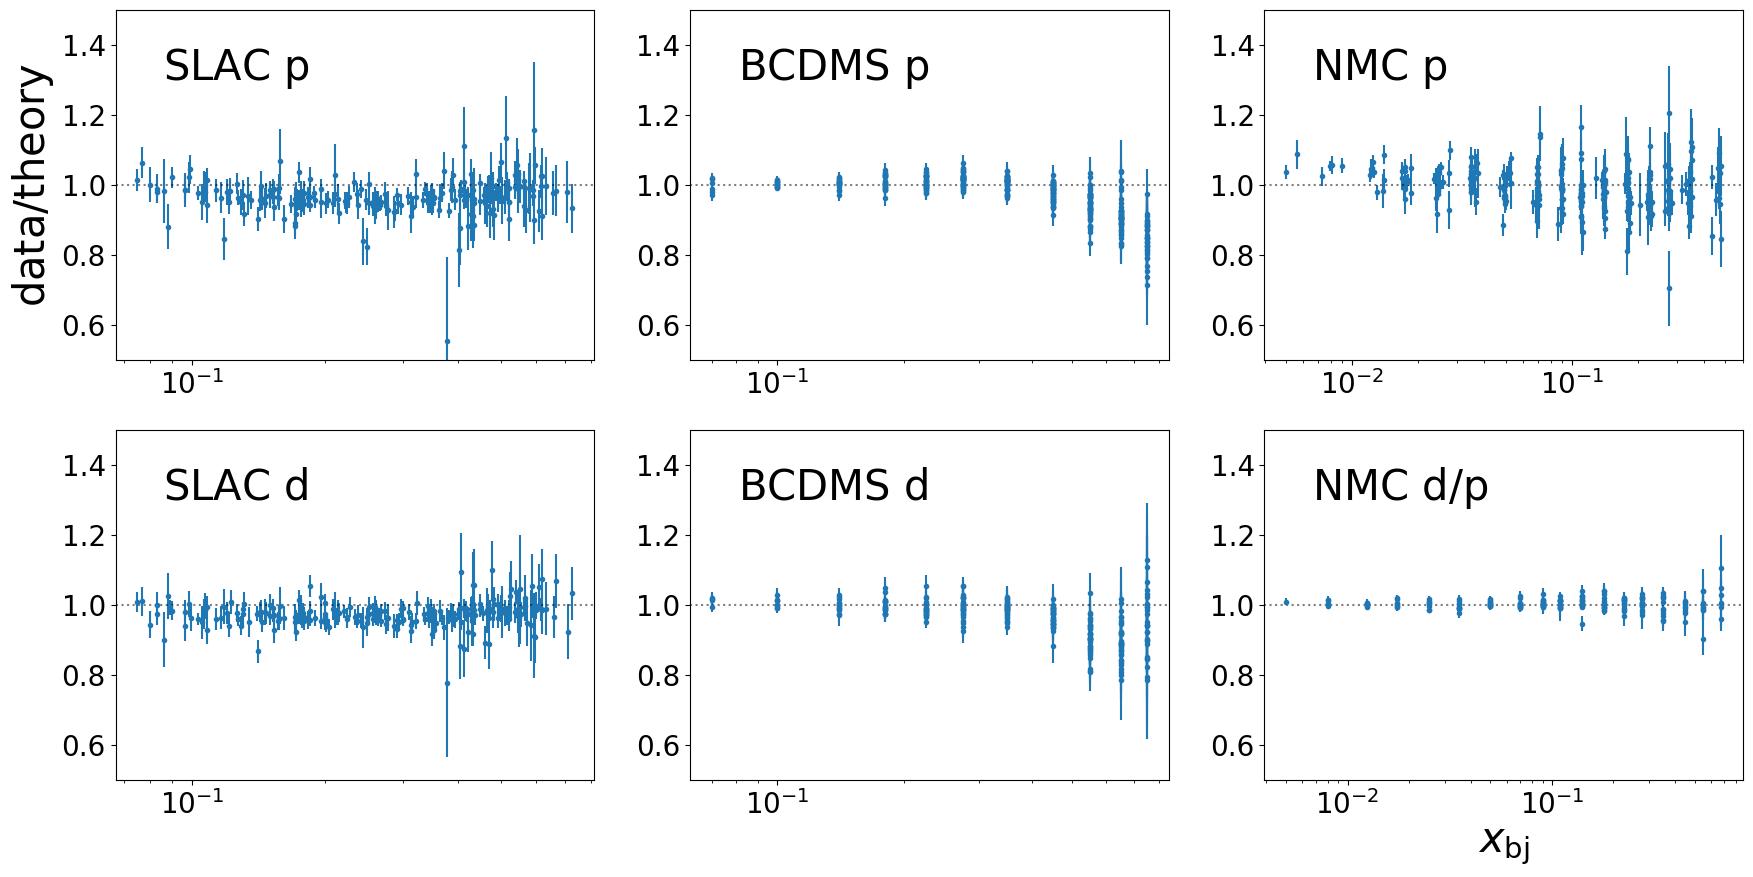

In [ ]:
par1=maxlike.sol  #--save this vector of parameters

conf={}
setup_params()
get_datasets(Q2cut=1.27**2, W2cut=10, ihera=False)
conf['order']     = 1
conf['mu20']      = 1.27**2
resman=RESMAN()

resman.get_residuals(par1)

tabs=resman.idis_tabs
nrows,ncols = math.ceil(len(tabs.keys())/3),3
fig = py.figure(figsize=(ncols*7,nrows*5))

cnt=0
for idx in tabs:
    cnt+=1
    ax = py.subplot(nrows,ncols,cnt)
    tab=tabs[idx]
    ax.errorbar(tab['X'],tab['value']/tab['thy'],tab['alpha']/tab['thy'],fmt='.')
    ax.set_ylim(0.5,1.5)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.semilogx()
    if cnt==1: ax.set_ylabel(r'$\rm data/theory$',size=30)
    msg=r'$\rm %s~%s$'%(tab['col'][0],tab['target'][0])
    ax.text(0.1,0.8,msg,transform=ax.transAxes,size=30)
    ax.axhline(1,0,1,color='black',ls=':',alpha=0.5)
ax.set_xlabel(r'$x_{\rm bj}$',size=30);

## Exercise 10.A
- Plot $xu_v$, $xd_v$, $d/u$, $x(\bar{d}-\bar{u})$, $R_s=(\bar{d}+\bar{u})/(s+\bar{s})$, $xg$ at the scale $\mu^2 = 10$ GeV$^2$
- **Hint**: Use the function `conf['pdf'].get_xF(x,mu2,flav)` after updating the parameters of the `PDF` class.

### Exercise 10.B

- Include the HERA data sets and run the fitter again
- Plot data/theory for all experiments
- Plot the PDFs (as above) from the previous run and the new run
- **Hints**:
  + Use `get_datasets(Q2cut=1.27**2, W2cut=10, ihera=True)`
  + Assuming you have the two sets of parameters stored as par1 and par2, use the method `resman.parman.set_new_params(par)` to update the `PDF` class with the new parameters.

You have now successfully run a fit!  Congratulations! 🎉

The next step is to repeat this process hundreds/thousands of times, reshuffling the data within its uncertainty each time.  Each reshuffling will lead to a new set of parameters, which we call a "replica."  Once we have hundreds/thousands of them, we can plot all of them and use their average and standard deviation to form error bars for the PDFs.

Modern global analyses done by the JAM collaboration go beyond fitting a single object (PDFs) to a single process (DIS).  Some of the latest JAM analyses may involve simultaneously fitting 5 or more objects to 25 or more observables.